<a href="https://colab.research.google.com/github/metsumesquita/master_degree_UPE/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importaçoes

In [10]:
!pip install xlrd

In [11]:
!pip install calplot

In [12]:
#produto garteziano
from itertools import product
#loop thing
from tqdm.notebook import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import keras as ks
import matplotlib.pyplot as plt
import xlrd
import requests
import json
import calplot
import seaborn as sns

#conjunto de dados

In [14]:
# URL to the JSON data
url = 'https://ws.jakarta.go.id/gateway/DataPortalSatuDataJakarta/1.0/satudata?kategori=dataset&tipe=detail&url=indeks-standar-pencemaran-udara-ispu-tahun-2017'

# Send a GET request to fetch the raw JSON data
response = requests.get(url)

# Check the response status code
if response.status_code == 200:
    # Parse the JSON data
    data_json = response.json()

    # Now you can work with the data
    # For example, to print the entire JSON data:
    print(data_json)
else:
    print("Error fetching data:", response.status_code)


{'data': [{'periode_data': '201701', 'tanggal': '2017-01-27', 'stasiun': 'DKI5 (Kebon Jeruk)', 'pm10': '5', 'so2': '11', 'co': '29', 'o3': '37', 'no2': '14', 'max': '37', 'critical': 'O3', 'categori': 'BAIK'}, {'periode_data': '201701', 'tanggal': '2017-01-28', 'stasiun': 'DKI5 (Kebon Jeruk)', 'pm10': '5', 'so2': '11', 'co': '28', 'o3': '42', 'no2': '6', 'max': '42', 'critical': 'O3', 'categori': 'BAIK'}, {'periode_data': '201701', 'tanggal': '2017-01-29', 'stasiun': 'DKI5 (Kebon Jeruk)', 'pm10': '6', 'so2': '11', 'co': '29', 'o3': '26', 'no2': '13', 'max': '29', 'critical': 'CO', 'categori': 'BAIK'}, {'periode_data': '201701', 'tanggal': '2017-01-30', 'stasiun': 'DKI5 (Kebon Jeruk)', 'pm10': '7', 'so2': '11', 'co': '28', 'o3': '41', 'no2': '5', 'max': '41', 'critical': 'O3', 'categori': 'BAIK'}, {'periode_data': '201701', 'tanggal': '2017-01-31', 'stasiun': 'DKI5 (Kebon Jeruk)', 'pm10': '6', 'so2': '11', 'co': '26', 'o3': '42', 'no2': '7', 'max': '42', 'critical': 'O3', 'categori': 'B

In [15]:
df = pd.DataFrame(data_json['data'])

In [16]:
df.columns

Index(['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2',
       'max', 'critical', 'categori'],
      dtype='object')

In [17]:
df.info()
# 10 attributes with 1827 rows of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   periode_data  1825 non-null   object
 1   tanggal       1825 non-null   object
 2   stasiun       1825 non-null   object
 3   pm10          1825 non-null   object
 4   so2           1825 non-null   object
 5   co            1825 non-null   object
 6   o3            1825 non-null   object
 7   no2           1825 non-null   object
 8   max           1825 non-null   object
 9   critical      1800 non-null   object
 10  categori      1825 non-null   object
dtypes: object(11)
memory usage: 157.0+ KB


In [18]:
df.describe()
#365 days - 1 year -TAGGAL needs to change type

periode_data     tanggal             stasiun  pm10   so2    co    o3  \
count          1825        1825                1825  1825  1825  1825  1825   
unique           12         365                   5   102    54    66   149   
top          201701  2017-01-27  DKI5 (Kebon Jeruk)   ---    18   ---   ---   
freq            155           5                 365   115   115    95    87   

         no2   max critical categori  
count   1825  1825     1800     1825  
unique    31   143        6        4  
top        5    53       O3   SEDANG  
freq     173    52     1152     1121

In [19]:
#selecionadoas colunas como o do artigo
df = df[['tanggal','stasiun', 'pm10', 'so2', 'co','o3','no2']]
print(df.tail)

<bound method NDFrame.tail of          tanggal             stasiun pm10 so2  co  o3 no2
0     2017-01-27  DKI5 (Kebon Jeruk)    5  11  29  37  14
1     2017-01-28  DKI5 (Kebon Jeruk)    5  11  28  42   6
2     2017-01-29  DKI5 (Kebon Jeruk)    6  11  29  26  13
3     2017-01-30  DKI5 (Kebon Jeruk)    7  11  28  41   5
4     2017-01-31  DKI5 (Kebon Jeruk)    6  11  26  42   7
...          ...                 ...  ...  ..  ..  ..  ..
1820  2017-12-27  DKI5 (Kebon Jeruk)   21  21  26  30   4
1821  2017-12-28  DKI5 (Kebon Jeruk)   29  23  26  46   5
1822  2017-12-29  DKI5 (Kebon Jeruk)   55  28  38  47  10
1823  2017-12-30  DKI5 (Kebon Jeruk)   51  26  31  49   8
1824  2017-12-31  DKI5 (Kebon Jeruk)   52  23  40  33   8

[1825 rows x 7 columns]>


#mudança de tipos e renomenclatura de colunas

In [20]:
df = df.replace('---',None)

In [21]:
import pandas as pd
df[['pm10', 'so2', 'co','o3','no2']] = df[['pm10', 'so2', 'co','o3','no2']].apply(pd.to_numeric)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  1825 non-null   object 
 1   stasiun  1825 non-null   object 
 2   pm10     1710 non-null   float64
 3   so2      1746 non-null   float64
 4   co       1730 non-null   float64
 5   o3       1738 non-null   float64
 6   no2      1739 non-null   float64
dtypes: float64(5), object(2)
memory usage: 99.9+ KB


In [23]:
df.describe()

pm10          so2           co           o3          no2
count  1710.000000  1746.000000  1730.000000  1738.000000  1739.000000
mean     48.233333    26.259450    19.423121    63.769275     8.956872
std      18.922649    13.414602    11.659282    29.821369     5.173167
min       2.000000     3.000000     1.000000     6.000000     1.000000
25%      35.000000    16.000000    11.000000    41.000000     5.000000
50%      52.000000    21.000000    17.000000    61.000000     8.000000
75%      60.000000    34.000000    25.000000    84.000000    12.000000
max     118.000000    55.000000    93.000000   168.000000    31.000000

In [24]:
df.head()

tanggal             stasiun  pm10   so2    co    o3   no2
0  2017-01-27  DKI5 (Kebon Jeruk)   5.0  11.0  29.0  37.0  14.0
1  2017-01-28  DKI5 (Kebon Jeruk)   5.0  11.0  28.0  42.0   6.0
2  2017-01-29  DKI5 (Kebon Jeruk)   6.0  11.0  29.0  26.0  13.0
3  2017-01-30  DKI5 (Kebon Jeruk)   7.0  11.0  28.0  41.0   5.0
4  2017-01-31  DKI5 (Kebon Jeruk)   6.0  11.0  26.0  42.0   7.0

In [25]:
df[20:50]

tanggal               stasiun  pm10   so2    co    o3   no2
20  2017-02-16    DKI1 (Bunderan HI)  36.0   7.0  19.0  38.0   3.0
21  2017-02-17    DKI1 (Bunderan HI)  52.0   4.0  30.0  33.0   4.0
22  2017-02-18    DKI1 (Bunderan HI)  68.0   7.0  25.0  30.0   4.0
23  2017-02-19    DKI1 (Bunderan HI)  57.0   4.0  34.0  25.0   2.0
24  2017-02-20    DKI1 (Bunderan HI)  40.0   3.0  31.0  24.0   3.0
25  2017-02-21    DKI1 (Bunderan HI)  51.0   3.0  34.0  46.0   4.0
26  2017-02-22    DKI1 (Bunderan HI)  58.0  15.0  25.0  78.0   5.0
27  2017-02-23    DKI1 (Bunderan HI)  52.0   7.0  27.0  71.0   7.0
28  2017-02-24    DKI1 (Bunderan HI)  62.0   7.0  30.0  67.0   5.0
29  2017-02-25    DKI1 (Bunderan HI)  50.0   6.0  24.0  68.0   3.0
30  2017-02-26    DKI1 (Bunderan HI)  44.0   8.0  25.0  60.0   4.0
31  2017-02-27    DKI1 (Bunderan HI)  30.0   6.0  23.0  44.0   4.0
32  2017-02-28    DKI1 (Bunderan HI)  58.0   6.0  26.0  54.0   4.0
33  2017-02-01  DKI2 (Kelapa Gading)  27.0  21.0  13.0  36.0  12.0
34  2017-02-02  DKI2 (Kelapa Gading)  37.0  22.0  18.0  36.0  16.0
35  2017-02-03  DKI2 (Kelapa Gading)  37.0  21.0  19.0  45.0  13.0
36  2017-02-04  DKI2 (Kelapa Gading)  20.0  20.0   9.0  38.0   7.0
37  2017-02-05  DKI2 (Kelapa Gading)  21.0  18.0   5.0  37.0   5.0
38  2017-02-06  DKI2 (Kelapa Gading)  22.0  18.0   6.0  34.0   7.0
39  2017-02-07  DKI2 (Kelapa Gading)  25.0  19.0   6.0  33.0   8.0
40  2017-02-08  DKI2 (Kelapa Gading)  25.0  19.0   NaN  28.0  12.0
41  2017-02-09  DKI2 (Kelapa Gading)  35.0  18.0  11.0  41.0  14.0
42  2017-02-10  DKI2 (Kelapa Gading)  28.0  17.0  11.0  44.0  12.0
43  2017-02-11  DKI2 (Kelapa Gading)  30.0  18.0  14.0  43.0  11.0
44  2017-02-12  DKI2 (Kelapa Gading)  25.0  16.0   5.0  44.0  12.0
45  2017-02-13  DKI2 (Kelapa Gading)  33.0  18.0  11.0  53.0  12.0
46  2017-02-14  DKI2 (Kelapa Gading)  37.0  18.0  17.0  47.0  14.0
47  2017-02-15  DKI2 (Kelapa Gading)  21.0  18.0  10.0  46.0  12.0
48  2017-02-16  DKI2 (Kelapa Gading)  22.0  18.0  11.0  46.0  11.0
49  2017-02-17  DKI2 (Kelapa Gading)  29.0  21.0  18.0  50.0  15.0

In [26]:
df.rename(columns={'stasiun':'Region','tanggal':'Date','pm10':'PM10','so2':'SO2','co':'CO','o3':'O3','no2':'NO2'}, inplace=True)

In [27]:
## Restaurando a coluna como uma coluna comum
#df.reset_index(inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1825 non-null   object 
 1   Region  1825 non-null   object 
 2   PM10    1710 non-null   float64
 3   SO2     1746 non-null   float64
 4   CO      1730 non-null   float64
 5   O3      1738 non-null   float64
 6   NO2     1739 non-null   float64
dtypes: float64(5), object(2)
memory usage: 99.9+ KB


#regiao - DKI1 (Bunderan HI) -selecionada

In [29]:
dk1_data = df[df['Region'] =='DKI1 (Bunderan HI)']

In [30]:
dk1_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 5 to 1656
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    365 non-null    object 
 1   Region  365 non-null    object 
 2   PM10    352 non-null    float64
 3   SO2     338 non-null    float64
 4   CO      353 non-null    float64
 5   O3      349 non-null    float64
 6   NO2     352 non-null    float64
dtypes: float64(5), object(2)
memory usage: 22.8+ KB


In [31]:
# Remover a coluna 'Region' da cópia
dk1_data =dk1_data.drop('Region', axis=1)

#retirada das horas - sempre a mesma hora

In [32]:
dk1_data['Date'] = pd.to_datetime(dk1_data['Date'], format='%Y-%m-%d')

In [33]:
dk1_data

Date  PM10   SO2    CO    O3  NO2
5    2017-02-01  41.0  16.0  22.0  27.0  3.0
6    2017-02-02  49.0   NaN  23.0  41.0  3.0
7    2017-02-03  53.0   NaN  28.0  34.0  3.0
8    2017-02-04  30.0   NaN  17.0  35.0  2.0
9    2017-02-05  22.0   NaN  15.0  37.0  2.0
...         ...   ...   ...   ...   ...  ...
1652 2017-11-26  28.0  20.0  15.0  18.0  2.0
1653 2017-11-27  20.0  18.0  16.0  19.0  2.0
1654 2017-11-28  19.0  18.0  16.0  21.0  2.0
1655 2017-11-29  23.0  19.0  16.0  28.0  3.0
1656 2017-11-30  29.0  21.0  23.0  18.0  4.0

[365 rows x 6 columns]

In [34]:
# Verificando e removendo duplicatas
dk1_data.drop_duplicates(subset='Date', keep='first', inplace=True)

In [35]:
dk1_data.head()

Date  PM10   SO2    CO    O3  NO2
5 2017-02-01  41.0  16.0  22.0  27.0  3.0
6 2017-02-02  49.0   NaN  23.0  41.0  3.0
7 2017-02-03  53.0   NaN  28.0  34.0  3.0
8 2017-02-04  30.0   NaN  17.0  35.0  2.0
9 2017-02-05  22.0   NaN  15.0  37.0  2.0

In [36]:
# Remove the hour component using dt.normalize()
#dk1_data['Date'] = dk1_data['Date'].dt.normalize()

##Realiza o cálculo da porcentagem de dados nulos por coluna

In [37]:
dk1_data.isnull().sum()/dk1_data.shape[0]*100

Date    0.000000
PM10    3.561644
SO2     7.397260
CO      3.287671
O3      4.383562
NO2     3.561644
dtype: float64

#index data

In [38]:
#https://towardsdatascience.com/time-series-data-introduction-ad2114cfdfa3
#https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
#https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/
#https://medium.com/@poojamore282/an-introduction-to-missing-value-imputation-in-univariate-time-series-7739a34e87e3
#https://www.geeksforgeeks.org/how-to-deal-with-missing-values-in-a-timeseries-in-python/
#https://www.forecastclub.blog/2024/02/how-to-handle-time-series-missing-data.html
#https://cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values

##https://python-graph-gallery.com/heatmap-for-timeseries-matplotlib/#:~:text=This%20post%20shows%20how%20to,a%20legend%20with%20a%20colorbar.
#https://medium.com/mcd-unison/how-to-create-heatmaps-for-time-series-with-python-c1253b0169d0

In [39]:
dk1 =dk1_data  # Assign the modified df to dk1_data directly

In [40]:
dk1 = dk1_data.set_index('Date')

In [41]:
print(dk1.index.is_monotonic_increasing)  # Retorna True ou False


False


In [42]:
dk1 = dk1.sort_index()  # Ordena o DataFrame pelo índice


In [43]:
#USING
#https://medium.com/enjoy-algorithm/pre-processing-of-time-series-data-c50f8a3e7a98

#procurando coorelaçao

In [44]:
#https://python-graph-gallery.com/heatmap-for-timeseries-matplotlib/#:~:text=This%20post%20shows%20how%20to,a%20legend%20with%20a%20colorbar.
#https://medium.com/mcd-unison/how-to-create-heatmaps-for-time-series-with-python-c1253b0169d0

In [45]:
dk1.head()

PM10   SO2    CO    O3  NO2
Date                                   
2017-01-01  63.0  34.0  25.0  21.0  2.0
2017-01-02  16.0  32.0  16.0  19.0  1.0
2017-01-03  18.0  32.0  17.0  20.0  2.0
2017-01-04  24.0  32.0  22.0  20.0  2.0
2017-01-05  29.0  32.0  25.0  14.0  2.0

In [46]:
# Selecionando as colunas numéricas para calcular a correlação
numerical_data = dk1[['PM10', 'SO2', 'CO', 'O3', 'NO2']]  # Ajuste as colunas conforme seu conjunto de dados

# Calculando a matriz de correlação
correlation_matrix = numerical_data.corr()

print(correlation_matrix)


          PM10       SO2        CO        O3       NO2
PM10  1.000000 -0.170801  0.393927  0.498815  0.546986
SO2  -0.170801  1.000000 -0.293382 -0.023117 -0.074702
CO    0.393927 -0.293382  1.000000  0.085016  0.213388
O3    0.498815 -0.023117  0.085016  1.000000  0.674077
NO2   0.546986 -0.074702  0.213388  0.674077  1.000000


## Plotar a matriz de correlação

<Axes: >

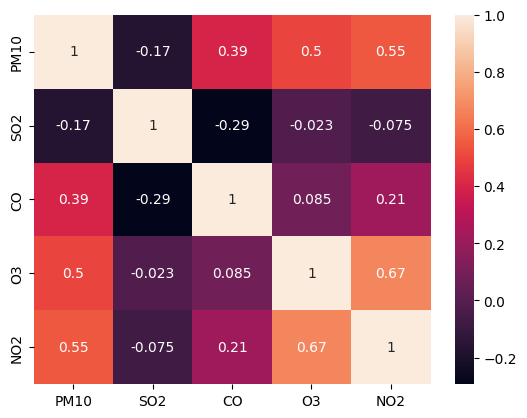

In [47]:
# Plotar a matriz de correlação

sns.heatmap(correlation_matrix, annot=True)
##
#PM10 e NO2 têm uma correlação moderada (~0.55), indicando que, à medida que uma aumenta, a outra tende a aumentar.
#O3 e NO2 têm uma forte correlação (~0.67).
#PM10 e O3 também estão positivamente correlacionadas (~0.50).

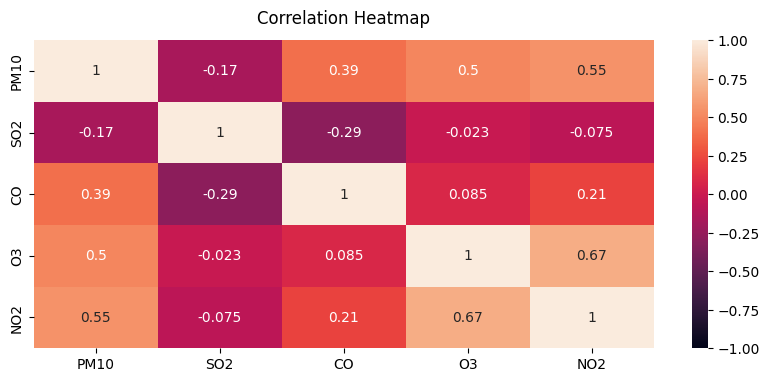

In [48]:
# Increase the size of the heatmap.
plt.figure(figsize=(10, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

# Função de Autocorrelação (ACF) - sazonalidade - NAO TERMINADO

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

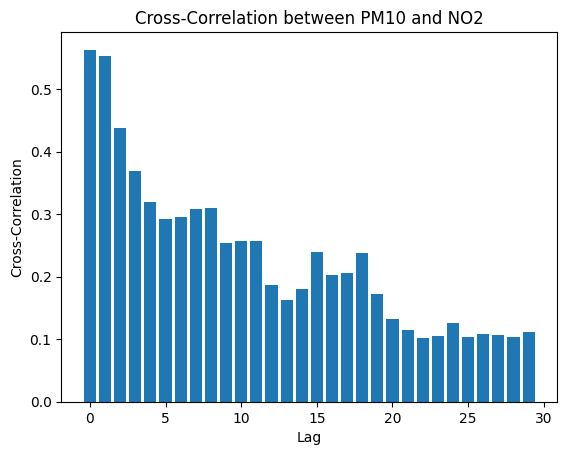

In [50]:
from statsmodels.tsa.stattools import ccf

# Exemplo de FACX entre PM10 e NO2
pm10_series = dk1['PM10'].interpolate(method='linear')  # Preencher valores faltantes, se necessário
no2_series = dk1['NO2'].interpolate(method='linear')

# Calculando a FACX
lag = 30  # Número de lags
facx = ccf(pm10_series, no2_series)[:lag]

# Plotando a FACX
plt.bar(range(lag), facx)
plt.title('Cross-Correlation between PM10 and NO2')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.show()


#PM10

###antes de interpolar PM10

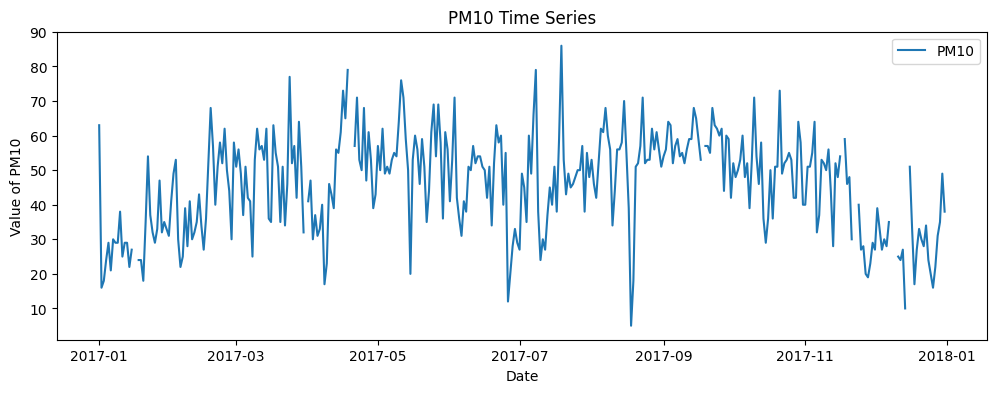

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(dk1.index, dk1['PM10'], label='PM10')
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of PM10")
plt.legend()
plt.show()


##depois de interpolar PM10

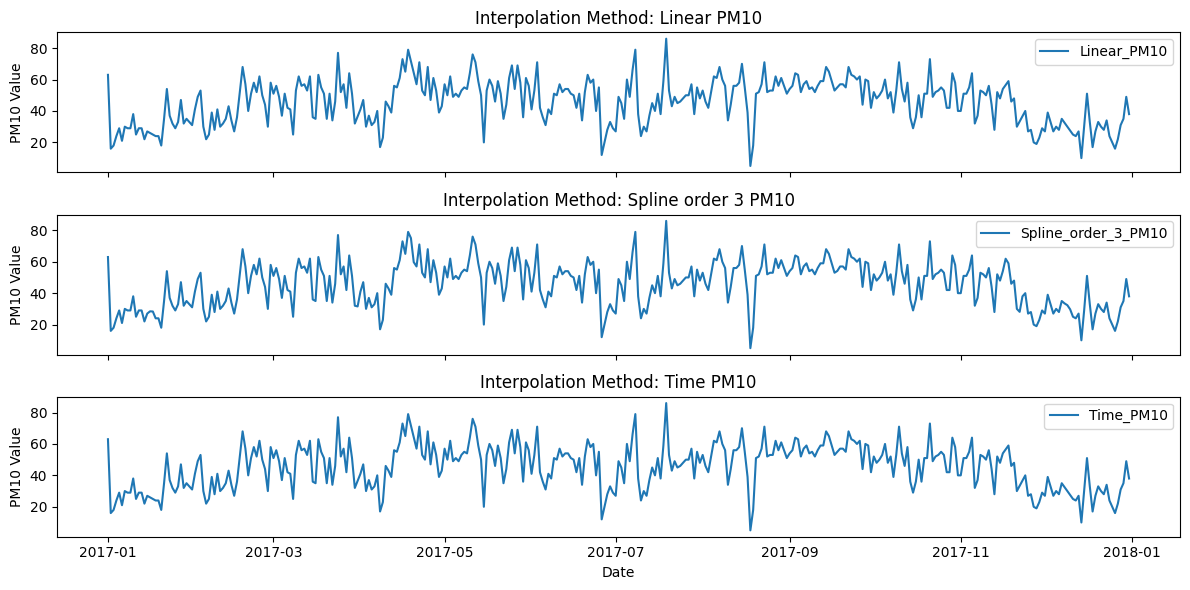

In [52]:
import matplotlib.pyplot as plt
dk1['Linear_PM10'] = dk1['PM10'].interpolate(method='linear')
dk1['Spline_order_3_PM10'] =dk1['PM10'].interpolate(method='spline', order=3)
dk1['Time_PM10'] = dk1['PM10'].interpolate(method='time')

# Métodos de interpolação
methods = ['Linear_PM10', 'Spline_order_3_PM10', 'Time_PM10']

# Configurando o tamanho da figura
fig, axes = plt.subplots(len(methods), 1, figsize=(12, 6), sharex=True)

# Criando gráficos individuais com títulos para cada método
for i, method in enumerate(methods):
    axes[i].plot(dk1.index, dk1[method], label=method)
    axes[i].set_title(f"Interpolation Method: {method.replace('_', ' ')}")  # Título dinâmico
    axes[i].set_ylabel('PM10 Value')
    axes[i].legend()

# Configurando o eixo X para todos os gráficos
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

##Analisando performance dos modelos utilizados INTER PM10

Linear Interpolation - MAE: 1.4397260273972603, RMSE: 8.14655056752015
Spline Interpolation - MAE: 1.4524652491420655, RMSE: 8.229584411821838
Time Interpolation - MAE: 1.4397260273972603, RMSE: 8.14655056752015
------------visualization------------


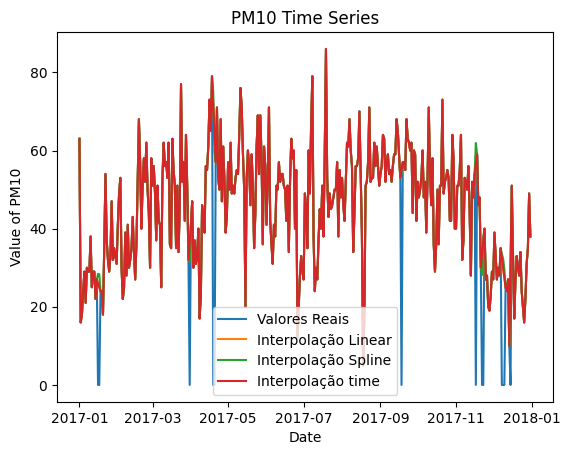

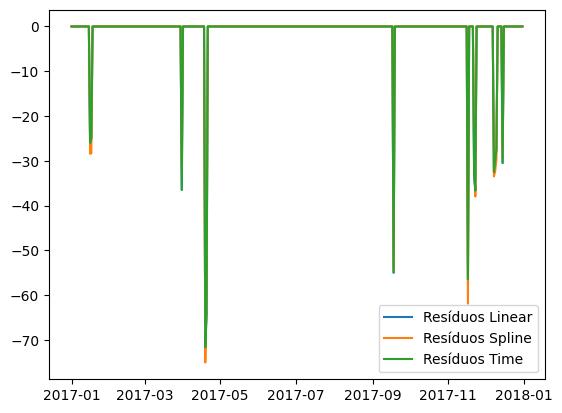

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['PM10'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_PM10']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_PM10']

interpolated_values_time = dk1.loc[real_values.index, 'Time_PM10']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Time Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")


print("------------visualization------------")
import matplotlib.pyplot as plt


# Plotar os resultados

# Plotar os resultados
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of PM10")
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')

plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()



#SO2

##antes de interpolar SO2

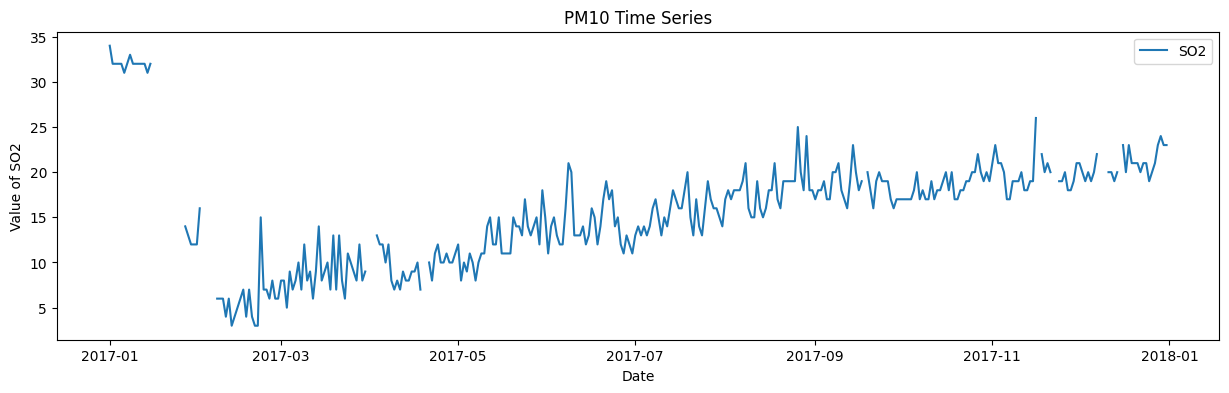

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(dk1.index, dk1['SO2'], label='SO2')
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of SO2")
plt.legend()
plt.show()


##depois de interpolar SO2

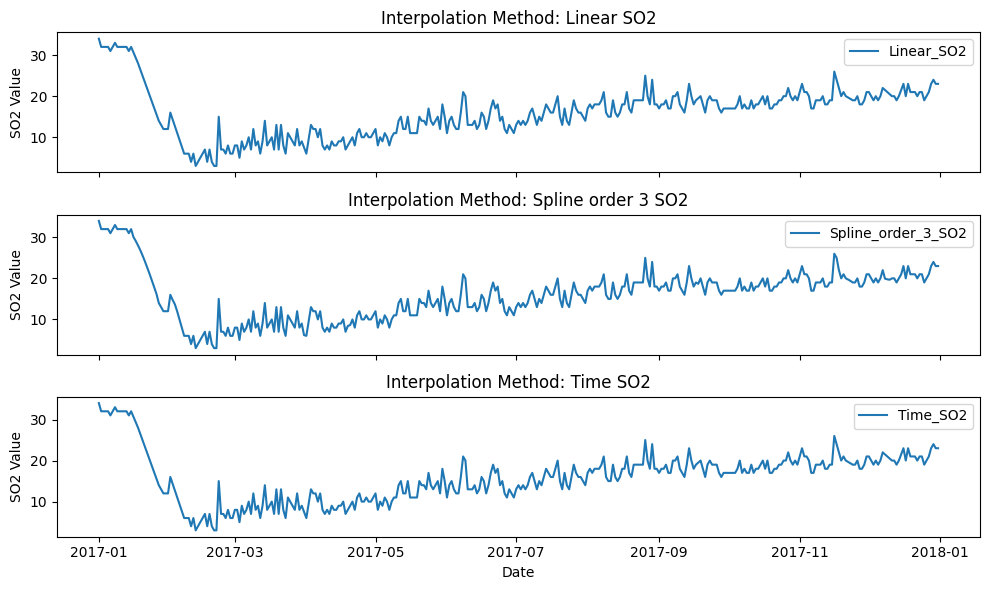

In [55]:
import matplotlib.pyplot as plt
dk1['Linear_SO2'] = dk1['SO2'].interpolate(method='linear')
dk1['Spline_order_3_SO2'] =dk1['SO2'].interpolate(method='spline', order=3)
dk1['Time_SO2'] = dk1['SO2'].interpolate(method='time')

# Métodos de interpolação
methods = ['Linear_SO2', 'Spline_order_3_SO2', 'Time_SO2']

# Configurando o tamanho da figura
fig, axes = plt.subplots(len(methods), 1, figsize=(10, 6), sharex=True)

# Criando gráficos individuais com títulos para cada método
for i, method in enumerate(methods):
    axes[i].plot(dk1.index, dk1[method], label=method)
    axes[i].set_title(f"Interpolation Method: {method.replace('_', ' ')}")  # Título dinâmico
    axes[i].set_ylabel('SO2 Value')
    axes[i].legend()

# Configurando o eixo X para todos os gráficos
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

##analise metrica performance SO2

Linear Interpolation - MAE: 1.326027397260274, RMSE: 5.196772405034792
Spline Interpolation - MAE: 1.333824859600633, RMSE: 5.2219566433456945
Spline Interpolation - MAE: 1.326027397260274, RMSE: 5.196772405034792
------------visualization------------


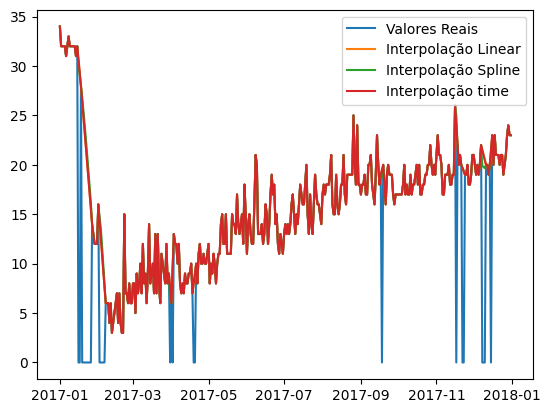

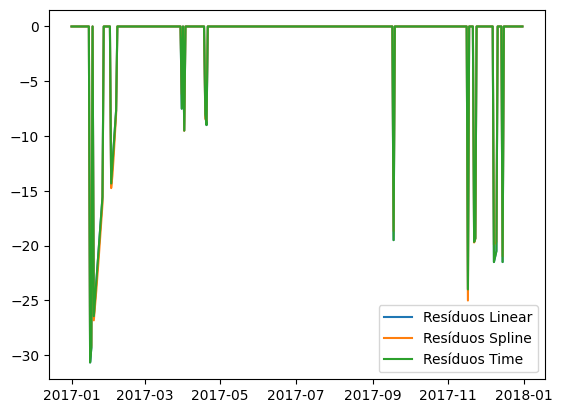

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['SO2'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_SO2']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_SO2']

interpolated_values_time = dk1.loc[real_values.index, 'Time_SO2']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Spline Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")

print("------------visualization------------")
import matplotlib.pyplot as plt


# Plotar os resultados
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')

plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()


##protanto RUIDOS DE CADA INTERPOLAÇAO DA VARIAVEL SO2

Linear Interpolation - MAE: 1.326027397260274, RMSE: 5.196772405034792
Spline Interpolation - MAE: 1.333824859600633, RMSE: 5.2219566433456945
Time Interpolation - MAE: 1.326027397260274, RMSE: 5.196772405034792
------------visualization------------


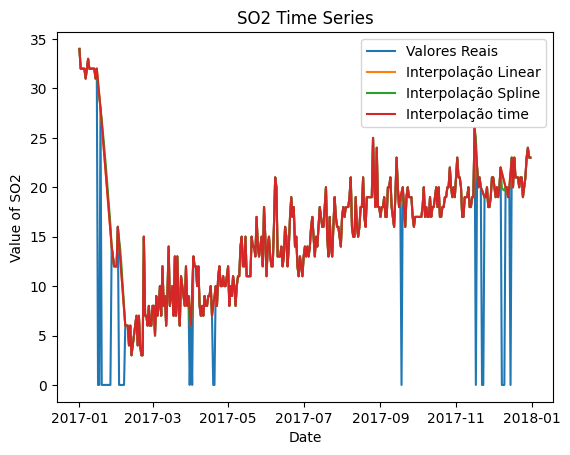

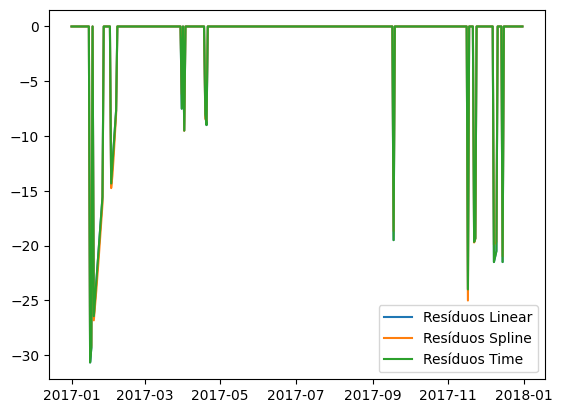

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['SO2'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_SO2']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_SO2']
interpolated_values_time = dk1.loc[real_values.index, 'Time_SO2']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Time Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")

print("------------visualization------------")
import matplotlib.pyplot as plt


# Plotar os resultados

# Plotar os resultados
plt.title("SO2 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of SO2")
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')

plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()


#CO

##antes de interpolar

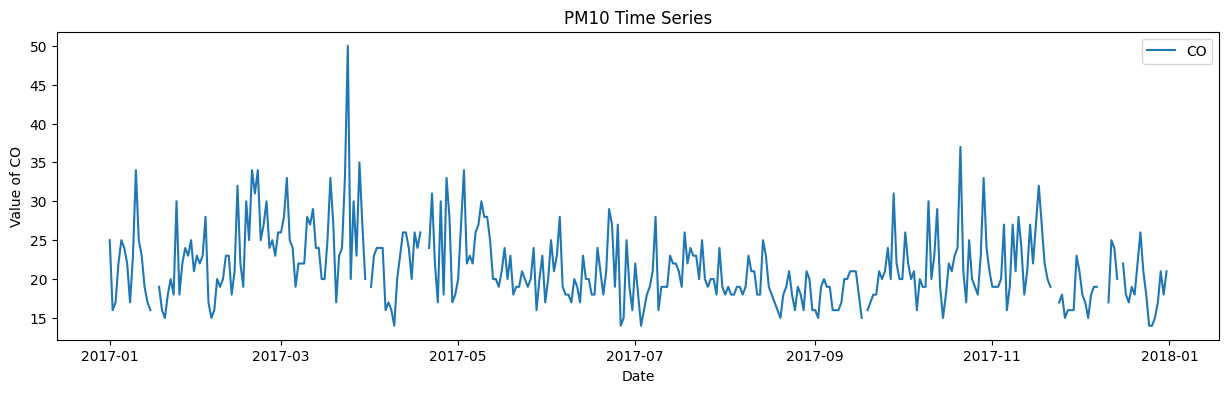

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(dk1.index, dk1['CO'], label='CO')
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of CO")
plt.legend()
plt.show()

##depois de interpolar CO

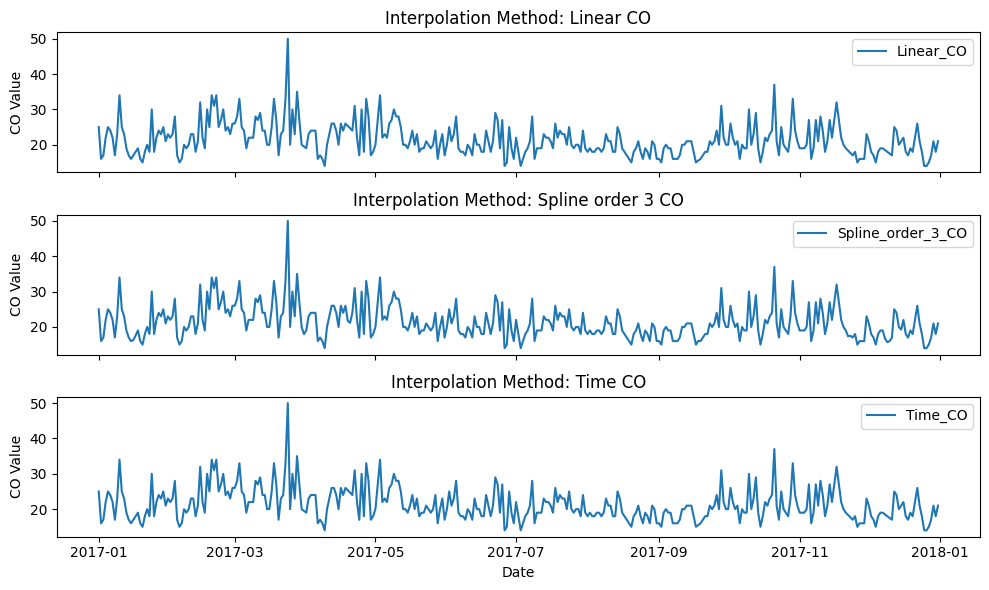

In [59]:
import matplotlib.pyplot as plt
dk1['Linear_CO'] = dk1['CO'].interpolate(method='linear')
dk1['Spline_order_3_CO'] =dk1['CO'].interpolate(method='spline', order=3)
dk1['Time_CO'] = dk1['CO'].interpolate(method='time')

# Métodos de interpolação
methods = ['Linear_CO', 'Spline_order_3_CO', 'Time_CO']

# Configurando o tamanho da figura
fig, axes = plt.subplots(len(methods), 1, figsize=(10, 6), sharex=True)

# Criando gráficos individuais com títulos para cada método
for i, method in enumerate(methods):
    axes[i].plot(dk1.index, dk1[method], label=method)
    axes[i].set_title(f"Interpolation Method: {method.replace('_', ' ')}")  # Título dinâmico
    axes[i].set_ylabel('CO Value')
    axes[i].legend()

# Configurando o eixo X para todos os gráficos
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

##ANALISE PERFORMANCE CO inter metdo

Linear Interpolation - MAE: 0.6328767123287671, RMSE: 3.5289194451747865
Spline Interpolation - MAE: 0.5844335129406939, RMSE: 3.2415455433249094
Time Interpolation - MAE: 0.6328767123287671, RMSE: 3.5289194451747865
------------visualization------------


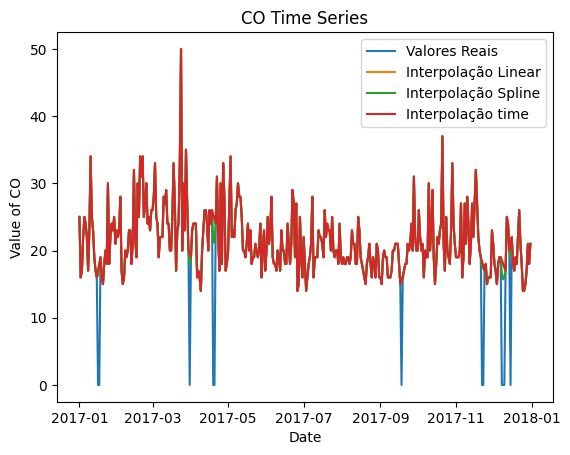

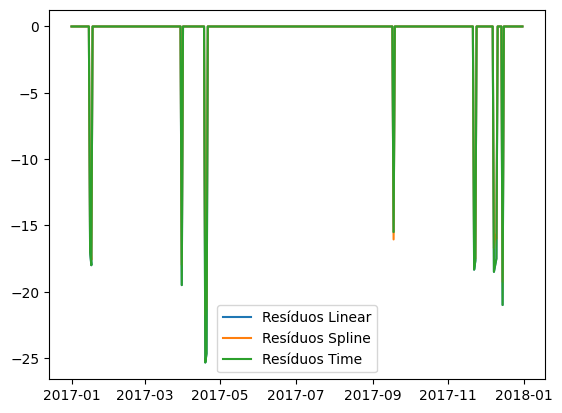

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['CO'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_CO']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_CO']

interpolated_values_time = dk1.loc[real_values.index, 'Time_CO']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Time Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")


print("------------visualization------------")
import matplotlib.pyplot as plt


# Plotar os resultados

# Plotar os resultados
plt.title("CO Time Series")
plt.xlabel("Date")
plt.ylabel("Value of CO")
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')

plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()


#O3

##antes de interpolar O3

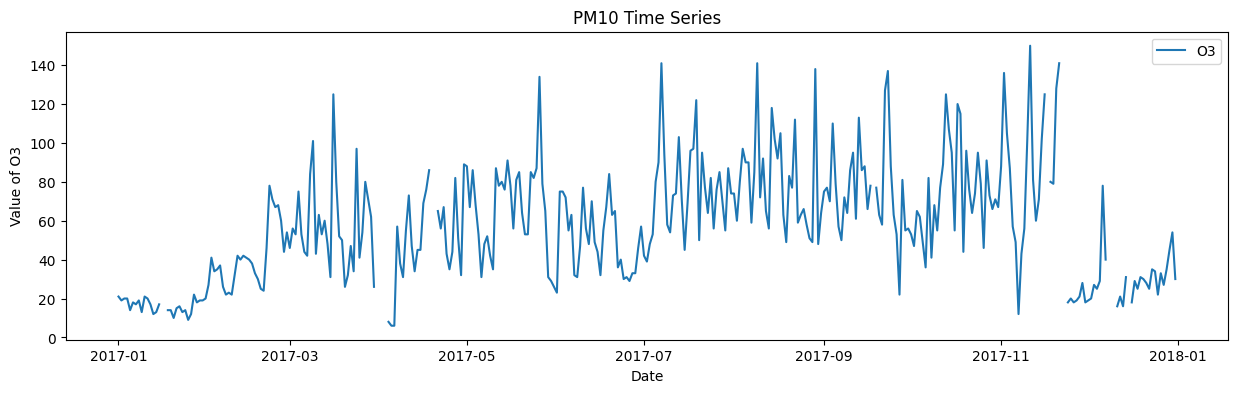

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4 ))
plt.plot(dk1.index, dk1['O3'], label='O3')
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of O3")
plt.legend()
plt.show()


##depois de interpolar

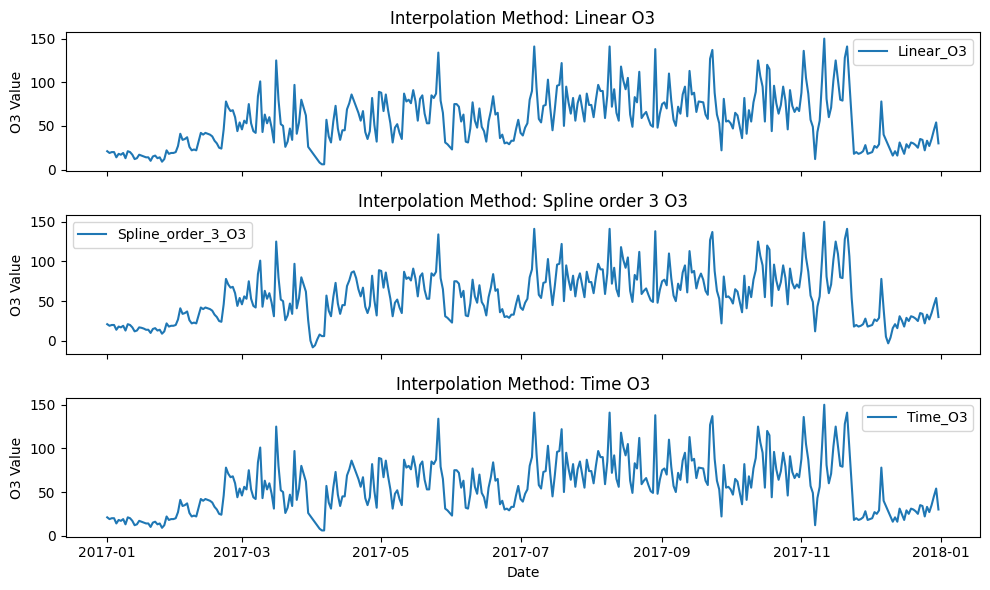

In [62]:
import matplotlib.pyplot as plt
dk1['Linear_O3'] = dk1['O3'].interpolate(method='linear')
dk1['Spline_order_3_O3'] =dk1['O3'].interpolate(method='spline', order=3)
dk1['Time_O3'] = dk1['O3'].interpolate(method='time')

# Métodos de interpolação
methods = ['Linear_O3', 'Spline_order_3_O3', 'Time_O3']

# Configurando o tamanho da figura
fig, axes = plt.subplots(len(methods), 1, figsize=(10, 6), sharex=True)

# Criando gráficos individuais com títulos para cada método
for i, method in enumerate(methods):
    axes[i].plot(dk1.index, dk1[method], label=method)
    axes[i].set_title(f"Interpolation Method: {method.replace('_', ' ')}")  # Título dinâmico
    axes[i].set_ylabel('O3 Value')
    axes[i].legend()

# Configurando o eixo X para todos os gráficos
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

##METRICA PERFORMANCE 03

Linear Interpolation - MAE: 1.9109589041095891, RMSE: 11.24381717467579
Spline Interpolation - MAE: 1.6629856087834836, RMSE: 11.537775334672025
Time Interpolation - MAE: 1.9109589041095891, RMSE: 11.24381717467579
------------visualization------------


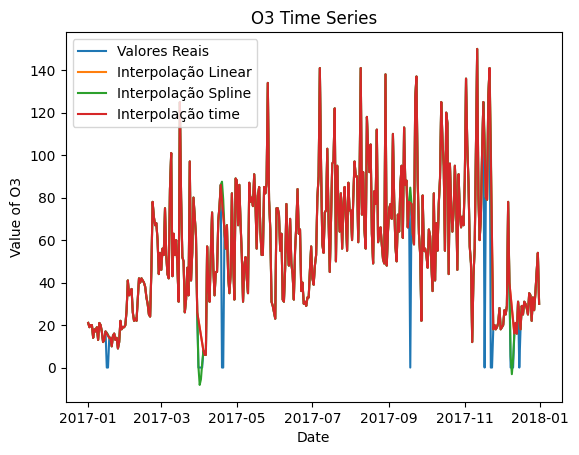

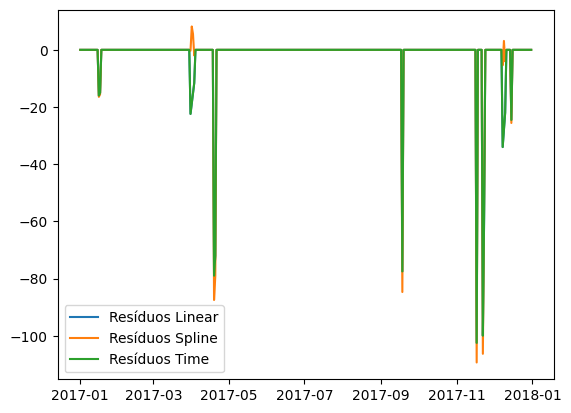

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['O3'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_O3']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_O3']
interpolated_values_time = dk1.loc[real_values.index, 'Time_O3']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Time Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")

print("------------visualization------------")
import matplotlib.pyplot as plt


# Plotar os resultados
plt.title("O3 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of O3")
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')

plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()


#NO2

##antes de interpolar no2

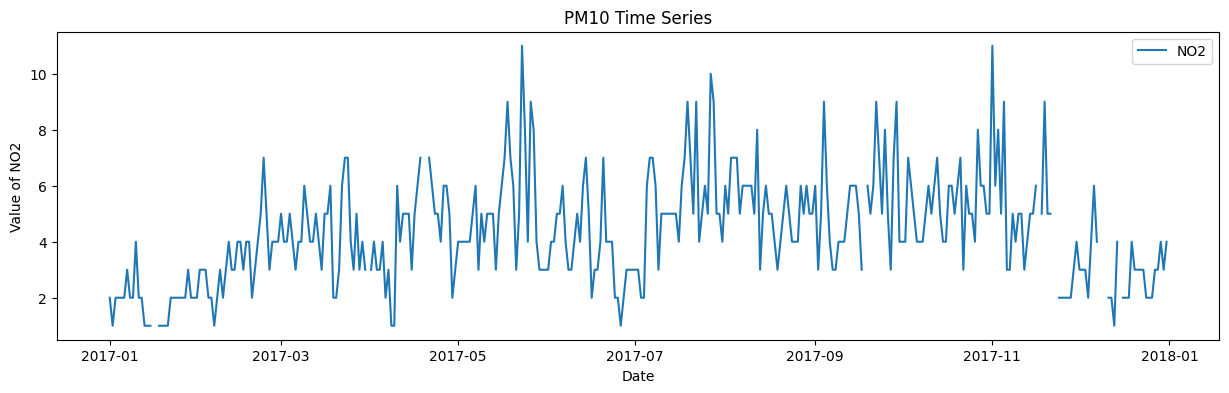

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(dk1.index, dk1['NO2'], label='NO2')
plt.title("PM10 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of NO2")
plt.legend()
plt.show()

##depois de interpolar NO2

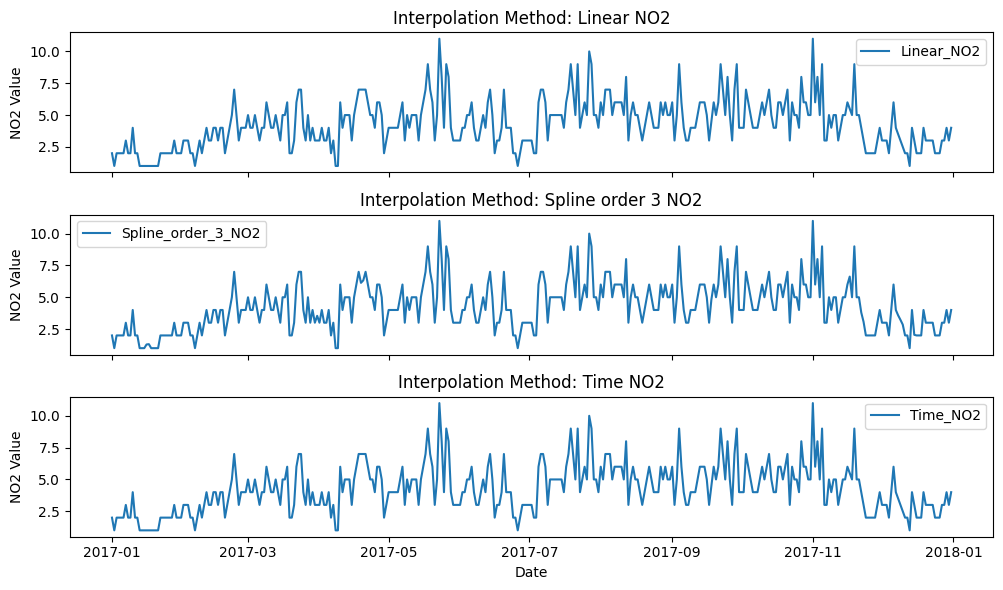

In [65]:
import matplotlib.pyplot as plt
dk1['Linear_NO2'] = dk1['NO2'].interpolate(method='linear')
dk1['Spline_order_3_NO2'] =dk1['NO2'].interpolate(method='spline', order=3)
dk1['Time_NO2'] = dk1['NO2'].interpolate(method='time')

# Métodos de interpolação
methods = ['Linear_NO2', 'Spline_order_3_NO2', 'Time_NO2']

# Configurando o tamanho da figura
fig, axes = plt.subplots(len(methods), 1, figsize=(10, 6), sharex=True)

# Criando gráficos individuais com títulos para cada método
for i, method in enumerate(methods):
    axes[i].plot(dk1.index, dk1[method], label=method)
    axes[i].set_title(f"Interpolation Method: {method.replace('_', ' ')}")  # Título dinâmico
    axes[i].set_ylabel('NO2 Value')
    axes[i].legend()

# Configurando o eixo X para todos os gráficos
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

##ANALISE PERFORMANCE NO2

Linear Interpolation - MAE: 0.13150684931506848, RMSE: 0.7781256017217236
Spline Interpolation - MAE: 0.1332314265411833, RMSE: 0.7765917343643145
Time Interpolation - MAE: 0.13150684931506848, RMSE: 0.7781256017217236
------------visualization------------


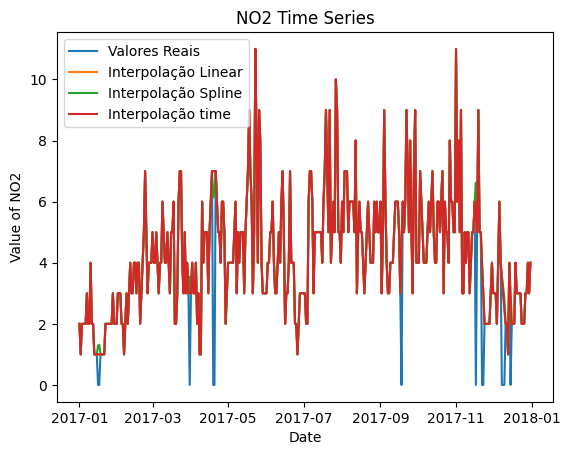

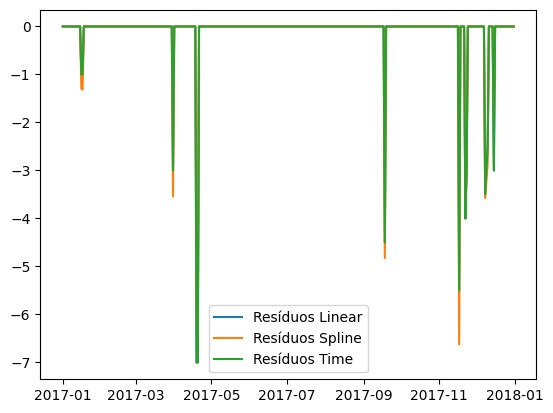

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Real values (garantindo que não contenham NaNs para as métricas)
real_values = dk1['NO2'].fillna(0)  # Remove valores ausentes

# Interpolated values (alinhando índices)
interpolated_values_linear = dk1.loc[real_values.index, 'Linear_NO2']
interpolated_values_spline = dk1.loc[real_values.index, 'Spline_order_3_NO2']

interpolated_values_time = dk1.loc[real_values.index, 'Time_NO2']

# Garantindo que as Séries estejam alinhadas e sem NaN
assert real_values.shape == interpolated_values_linear.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_spline.shape, "As dimensões não coincidem!"
assert real_values.shape == interpolated_values_time.shape,  "As dimensões não coincidem!"
# MAE
mae_linear = mean_absolute_error(real_values, interpolated_values_linear)
mae_spline = mean_absolute_error(real_values, interpolated_values_spline)
mae_time = mean_absolute_error(real_values, interpolated_values_time)
# RMSE
rmse_linear = np.sqrt(mean_squared_error(real_values, interpolated_values_linear))
rmse_spline = np.sqrt(mean_squared_error(real_values, interpolated_values_spline))
rmse_time = np.sqrt(mean_squared_error(real_values, interpolated_values_time))

print(f"Linear Interpolation - MAE: {mae_linear}, RMSE: {rmse_linear}")
print(f"Spline Interpolation - MAE: {mae_spline}, RMSE: {rmse_spline}")
print(f"Time Interpolation - MAE: {mae_time}, RMSE: {rmse_time}")

print("------------visualization------------")
import matplotlib.pyplot as plt



# Plotar os resultados
plt.title("NO2 Time Series")
plt.xlabel("Date")
plt.ylabel("Value of NO2")
plt.plot(real_values.index, real_values, label='Valores Reais')
plt.plot(real_values.index, interpolated_values_linear, label='Interpolação Linear')
plt.plot(real_values.index, interpolated_values_spline, label='Interpolação Spline')

plt.plot(real_values.index, interpolated_values_time, label='Interpolação time')
plt.legend()
plt.show()

# Plotar os resíduos (opcional)
plt.plot(real_values.index, real_values - interpolated_values_linear, label='Resíduos Linear')
plt.plot(real_values.index, real_values - interpolated_values_spline, label='Resíduos Spline')
plt.plot(real_values.index, real_values - interpolated_values_time, label='Resíduos Time')

plt.legend()
plt.show()

#lienar an time NO2

#IDK

In [70]:
dk1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-01-01 to 2017-12-31
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PM10                 352 non-null    float64
 1   SO2                  338 non-null    float64
 2   CO                   353 non-null    float64
 3   O3                   349 non-null    float64
 4   NO2                  352 non-null    float64
 5   Linear_PM10          365 non-null    float64
 6   Spline_order_3_PM10  365 non-null    float64
 7   Time_PM10            365 non-null    float64
 8   Linear_SO2           365 non-null    float64
 9   Spline_order_3_SO2   365 non-null    float64
 10  Time_SO2             365 non-null    float64
 11  Linear_CO            365 non-null    float64
 12  Spline_order_3_CO    365 non-null    float64
 13  Time_CO              365 non-null    float64
 14  Linear_O3            365 non-null    float64
 15  Spline_order_3_O3    

In [71]:
dk1.head()

PM10   SO2    CO    O3  NO2  Linear_PM10  Spline_order_3_PM10  \
Date                                                                        
2017-01-01  63.0  34.0  25.0  21.0  2.0         63.0                 63.0   
2017-01-02  16.0  32.0  16.0  19.0  1.0         16.0                 16.0   
2017-01-03  18.0  32.0  17.0  20.0  2.0         18.0                 18.0   
2017-01-04  24.0  32.0  22.0  20.0  2.0         24.0                 24.0   
2017-01-05  29.0  32.0  25.0  14.0  2.0         29.0                 29.0   

            Time_PM10  Linear_SO2  Spline_order_3_SO2  Time_SO2  Linear_CO  \
Date                                                                         
2017-01-01       63.0        34.0                34.0      34.0       25.0   
2017-01-02       16.0        32.0                32.0      32.0       16.0   
2017-01-03       18.0        32.0                32.0      32.0       17.0   
2017-01-04       24.0        32.0                32.0      32.0       22.0   
2017-01-05       29.0        32.0                32.0      32.0       25.0   

            Spline_order_3_CO  Time_CO  Linear_O3  Spline_order_3_O3  Time_O3  \
Date                                                                            
2017-01-01               25.0     25.0       21.0               21.0     21.0   
2017-01-02               16.0     16.0       19.0               19.0     19.0   
2017-01-03               17.0     17.0       20.0               20.0     20.0   
2017-01-04               22.0     22.0       20.0               20.0     20.0   
2017-01-05               25.0     25.0       14.0               14.0     14.0   

            Linear_NO2  Spline_order_3_NO2  Time_NO2  
Date                                                  
2017-01-01         2.0                 2.0       2.0  
2017-01-02         1.0                 1.0       1.0  
2017-01-03         2.0                 2.0       2.0  
2017-01-04         2.0                 2.0       2.0  
2017-01-05         2.0                 2.0       2.0

In [72]:
dk1.columns

Index(['PM10', 'SO2', 'CO', 'O3', 'NO2', 'Linear_PM10', 'Spline_order_3_PM10',
       'Time_PM10', 'Linear_SO2', 'Spline_order_3_SO2', 'Time_SO2',
       'Linear_CO', 'Spline_order_3_CO', 'Time_CO', 'Linear_O3',
       'Spline_order_3_O3', 'Time_O3', 'Linear_NO2', 'Spline_order_3_NO2',
       'Time_NO2'],
      dtype='object')

#df com as variaveis com mais de uma forma de interpolação

In [73]:
dk1_interpolete= dk1[['Linear_PM10','Spline_order_3_PM10',
       'Time_PM10', 'Linear_NO2', 'Spline_order_3_NO2', 'Time_NO2',
       'Linear_O3', 'Spline_order_3_O3', 'Time_O3', 'Linear_CO',
       'Spline_order_3_CO', 'Time_CO', 'Linear_SO2', 'Spline_order_3_SO2',
       'Time_SO2']]

In [74]:
#dk1_interpolete.to_csv('/content/drive/My Drive/df.csv', index=False)

CONJUNTO COM AS MELHORES INTERPOLAÇOES

In [75]:
####DATA INFORMAÇAO  as stationary data (PM10, CO,O3 and NO2) DE ACORDO COM O ARTIGO
Dk1_best_inter= dk1[['Time_PM10','Time_NO2','Spline_order_3_O3','Spline_order_3_CO','Time_SO2']]

In [76]:
Dk1_best_inter.head()

Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
Date                                                                    
2017-01-01       63.0       2.0               21.0               25.0   
2017-01-02       16.0       1.0               19.0               16.0   
2017-01-03       18.0       2.0               20.0               17.0   
2017-01-04       24.0       2.0               20.0               22.0   
2017-01-05       29.0       2.0               14.0               25.0   

            Time_SO2  
Date                  
2017-01-01      34.0  
2017-01-02      32.0  
2017-01-03      32.0  
2017-01-04      32.0  
2017-01-05      32.0

In [77]:
Dk1_best_inter.tail()

Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
Date                                                                    
2017-12-27       22.0       3.0               27.0               15.0   
2017-12-28       31.0       3.0               35.0               17.0   
2017-12-29       35.0       4.0               45.0               21.0   
2017-12-30       49.0       3.0               54.0               18.0   
2017-12-31       38.0       4.0               30.0               21.0   

            Time_SO2  
Date                  
2017-12-27      21.0  
2017-12-28      23.0  
2017-12-29      24.0  
2017-12-30      23.0  
2017-12-31      23.0

In [78]:
Dk1_best_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-01-01 to 2017-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_PM10          365 non-null    float64
 1   Time_NO2           365 non-null    float64
 2   Spline_order_3_O3  365 non-null    float64
 3   Spline_order_3_CO  365 non-null    float64
 4   Time_SO2           365 non-null    float64
dtypes: float64(5)
memory usage: 25.2 KB


In [79]:
#https://medium.com/@mouadenna/time-series-splitting-techniques-ensuring-accurate-model-validation-5a3146db3088
#https://datascience.stackexchange.com/questions/109937/how-to-train-test-split-a-timeseries
#https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9
#https://www.quora.com/Given-a-time-series-data-for-model-building-how-do-I-split-the-dataset-into-training-and-validation-samples

#estacionaridade  de cada coluna

In [80]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller


# Função para testar a estacionaridade de cada coluna
def testar_estacionaridade(df):
    resultados = {}
    for coluna in Dk1_best_inter.columns:
        resultado = adfuller(Dk1_best_inter[coluna])
        resultados[coluna] = {
            'ADF Statistic': resultado[0],
            'p-value': resultado[1],
            'Lags Used': resultado[2],
            'Number of Observations Used': resultado[3],
            'Critical Value (1%)': resultado[4]['1%'],
            'Critical Value (5%)': resultado[4]['5%'],
            'Critical Value (10%)': resultado[4]['10%']
        }
    return resultados

# Testando a estacionaridade
resultados = testar_estacionaridade(df)

# Exibindo os resultados
for coluna, res in resultados.items():
    print(f"Resultados para {coluna}:")
    for chave, valor in res.items():
        print(f"  {chave}: {valor}")
    print("\n")


Resultados para Time_PM10:
  ADF Statistic: -3.7288506342695764
  p-value: 0.003725167284055798
  Lags Used: 6
  Number of Observations Used: 358
  Critical Value (1%): -3.448748905151901
  Critical Value (5%): -2.8696473721448728
  Critical Value (10%): -2.5710891239349585


Resultados para Time_NO2:
  ADF Statistic: -2.9227724664250245
  p-value: 0.0427632337422974
  Lags Used: 13
  Number of Observations Used: 351
  Critical Value (1%): -3.44911857009962
  Critical Value (5%): -2.8698097654570507
  Critical Value (10%): -2.5711757061225153


Resultados para Spline_order_3_O3:
  ADF Statistic: -4.292825794889393
  p-value: 0.0004570926056593359
  Lags Used: 4
  Number of Observations Used: 360
  Critical Value (1%): -3.448645946352023
  Critical Value (5%): -2.869602139060357
  Critical Value (10%): -2.5710650077160495


Resultados para Spline_order_3_CO:
  ADF Statistic: -4.684625425936141
  p-value: 8.993083328117963e-05
  Lags Used: 5
  Number of Observations Used: 359
  Critical 

#informação para o artigo

In [81]:
#A série Time_PM10 é estacionária, pois o p-valor é menor que 0.05 e a estatística ADF é mais negativa do que os valores críticos de 1%, 5% e 10%
#a serie Time_NO2 é estacionária, pois o p-valor é menor que 0.05 e a estatística ADF é mais negativa do que os valores críticos de 5% e 10%
#Conclusão: A série Time_SO2 não é estacionária (não rejeitamos a hipótese nula), pois o p-valor é maior que 0.05, indicando que a série tem uma raiz unitária e pode precisar de transformações (como diferenciação) para se tornar estacionária.

*#DIFERENCIAÇÃO  NECESSARIA NA Time_SO2 - NAO FEITO*

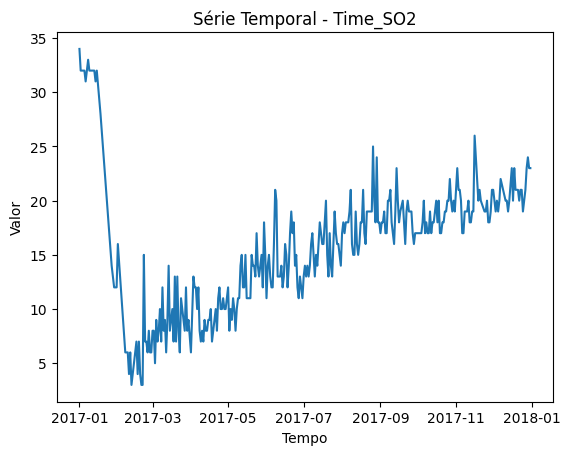

In [82]:
import matplotlib.pyplot as plt

# Plotar a série temporal
plt.plot(Dk1_best_inter['Time_SO2'])
plt.title("Série Temporal - Time_SO2")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()
#Tendência Geral: A série apresenta uma tendência de queda no início do período, seguida por uma estabilização e algumas flutuações.
#Sazonalidade: Não há uma sazonalidade clara e consistente na série.
#Variabilidade: A variabilidade da série parece ser relativamente constante ao longo do tempo.
#Outliers: Há alguns pontos que se destacam dos demais, podendo ser considerados outliers.


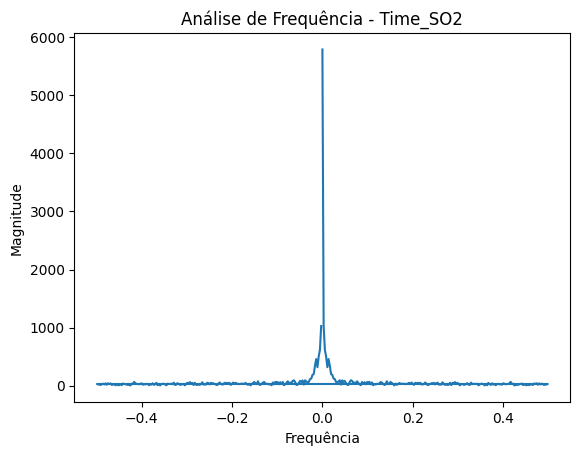

In [83]:
import numpy as np

# Calcular a transformada de Fourier
fft_result = np.fft.fft(Dk1_best_inter['Time_SO2'].dropna())
frequencies = np.fft.fftfreq(len(fft_result))

# Plotar as frequências
plt.plot(frequencies, np.abs(fft_result))
plt.title("Análise de Frequência - Time_SO2")
plt.xlabel("Frequência")
plt.ylabel("Magnitude")
plt.show()


In [84]:
#import pandas as pd
# Supondo que 'df' é seu DataFrame e 'coluna_valor' é a coluna com os valores da série temporal
#Dk1_best_inter['Time_SO2_diff'] = Dk1_best_inter['Time_SO2'].diff(periods=365)

In [85]:

#result = adfuller(Dk1_best_inter['Time_SO2_diff'].dropna())
#print(f'ADF Statistic: {result[0]}')
#print(f'p-value: {result[1]}')

In [86]:
#import pandas as pd
#Dk1_best_inter.drop('Time_SO2', axis=1, inplace=True)

#treino e testes separação

In [87]:
Dk1_best_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-01-01 to 2017-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_PM10          365 non-null    float64
 1   Time_NO2           365 non-null    float64
 2   Spline_order_3_O3  365 non-null    float64
 3   Spline_order_3_CO  365 non-null    float64
 4   Time_SO2           365 non-null    float64
dtypes: float64(5)
memory usage: 25.2 KB


In [88]:
# Dividir os dados

train_data = Dk1_best_inter.loc['2017-01-01':'2017-10-31']  # Treinamento: Janeiro a Outubro de 2017

test_data = Dk1_best_inter.loc['2017-11-01':'2017-12-31']   # Teste: Novembro e Dezembro de 2017


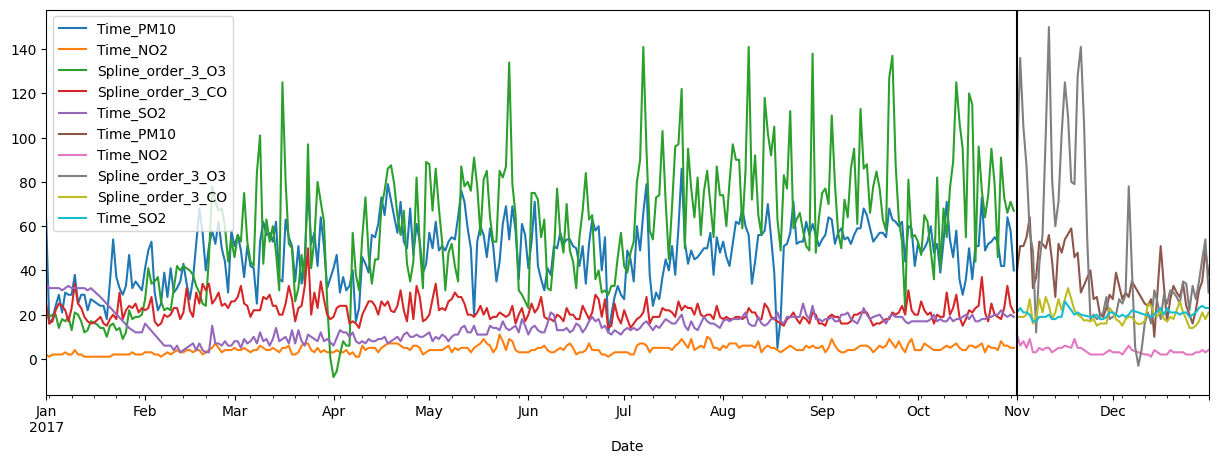

In [89]:
fig,ax = plt.subplots(figsize=(15,5))
train_data.plot(ax=ax,label='training set')
test_data.plot(ax=ax,label='test set')
ax.axvline('2017-11-01',color='black')
plt.show()

In [90]:
train_data.shape

(304, 5)

In [91]:
test_data.shape

(61, 5)

In [92]:
train_data

Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
Date                                                                    
2017-01-01       63.0       2.0               21.0               25.0   
2017-01-02       16.0       1.0               19.0               16.0   
2017-01-03       18.0       2.0               20.0               17.0   
2017-01-04       24.0       2.0               20.0               22.0   
2017-01-05       29.0       2.0               14.0               25.0   
...               ...       ...                ...                ...   
2017-10-27       42.0       8.0               91.0               18.0   
2017-10-28       42.0       6.0               73.0               23.0   
2017-10-29       64.0       6.0               66.0               33.0   
2017-10-30       58.0       5.0               71.0               24.0   
2017-10-31       40.0       5.0               67.0               21.0   

            Time_SO2  
Date                  
2017-01-01      34.0  
2017-01-02      32.0  
2017-01-03      32.0  
2017-01-04      32.0  
2017-01-05      32.0  
...              ...  
2017-10-27      22.0  
2017-10-28      20.0  
2017-10-29      19.0  
2017-10-30      20.0  
2017-10-31      19.0  

[304 rows x 5 columns]

In [93]:
test_data

Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
Date                                                                    
2017-11-01       40.0      11.0               88.0               19.0   
2017-11-02       51.0       6.0              136.0               19.0   
2017-11-03       51.0       8.0              105.0               19.0   
2017-11-04       55.0       5.0               87.0               20.0   
2017-11-05       64.0       9.0               57.0               27.0   
...               ...       ...                ...                ...   
2017-12-27       22.0       3.0               27.0               15.0   
2017-12-28       31.0       3.0               35.0               17.0   
2017-12-29       35.0       4.0               45.0               21.0   
2017-12-30       49.0       3.0               54.0               18.0   
2017-12-31       38.0       4.0               30.0               21.0   

            Time_SO2  
Date                  
2017-11-01      21.0  
2017-11-02      23.0  
2017-11-03      21.0  
2017-11-04      21.0  
2017-11-05      20.0  
...              ...  
2017-12-27      21.0  
2017-12-28      23.0  
2017-12-29      24.0  
2017-12-30      23.0  
2017-12-31      23.0  

[61 rows x 5 columns]

#normalização

In [94]:
from sklearn.preprocessing import MinMaxScaler

# Criar um scaler para cada série
scaler_pm10 = MinMaxScaler()
scaler_pm10.fit(train_data['Time_PM10'].values.reshape(-1, 1))

scaler_no2 = MinMaxScaler()
scaler_no2.fit(train_data['Time_NO2'].values.reshape(-1, 1))

scaler_so2 = MinMaxScaler()
scaler_so2.fit(train_data['Time_SO2'].values.reshape(-1, 1))

scaler_o3 = MinMaxScaler()
scaler_o3.fit(train_data['Spline_order_3_O3'].values.reshape(-1, 1))

scaler_co = MinMaxScaler()
scaler_co.fit(train_data['Spline_order_3_CO'].values.reshape(-1, 1))

# Normalizar os dados de treinamento
train_data_normalized = train_data.copy()
train_data_normalized['Time_PM10'] = scaler_pm10.transform(train_data['Time_PM10'].values.reshape(-1, 1))
train_data_normalized['Time_NO2'] = scaler_no2.transform(train_data['Time_NO2'].values.reshape(-1, 1))
train_data_normalized['Time_SO2'] = scaler_so2.transform(train_data['Time_SO2'].values.reshape(-1, 1))
train_data_normalized['Spline_order_3_O3'] = scaler_o3.transform(train_data['Spline_order_3_O3'].values.reshape(-1, 1))
train_data_normalized['Spline_order_3_CO'] = scaler_co.transform(train_data['Spline_order_3_CO'].values.reshape(-1, 1))

# Normalizar os dados de teste
test_data_normalized = test_data.copy()
test_data_normalized['Time_PM10'] = scaler_pm10.transform(test_data['Time_PM10'].values.reshape(-1, 1))
test_data_normalized['Time_NO2'] = scaler_no2.transform(test_data['Time_NO2'].values.reshape(-1, 1))
test_data_normalized['Time_SO2'] = scaler_so2.transform(test_data['Time_SO2'].values.reshape(-1, 1))
test_data_normalized['Spline_order_3_O3'] = scaler_o3.transform(test_data['Spline_order_3_O3'].values.reshape(-1, 1))
test_data_normalized['Spline_order_3_CO'] = scaler_co.transform(test_data['Spline_order_3_CO'].values.reshape(-1, 1))


In [95]:
print(train_data_normalized.describe())

        Time_PM10    Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
count  304.000000  304.000000         304.000000         304.000000   
mean     0.528529    0.343586           0.445441           0.213156   
std      0.169996    0.186553           0.194263           0.131940   
min      0.000000    0.000000           0.000000           0.000000   
25%      0.404321    0.200000           0.301167           0.111111   
50%      0.567901    0.300000           0.433560           0.194444   
75%      0.641975    0.500000           0.577684           0.277778   
max      1.000000    1.000000           1.000000           1.000000   

         Time_SO2  
count  304.000000  
mean     0.385240  
std      0.201844  
min      0.000000  
25%      0.250000  
50%      0.387097  
75%      0.483871  
max      1.000000  


In [96]:

print(test_data_normalized.describe())

       Time_PM10   Time_NO2  Spline_order_3_O3  Spline_order_3_CO   Time_SO2
count  61.000000  61.000000          61.000000          61.000000  61.000000
mean    0.378668   0.279508           0.386418           0.162812   0.561872
std     0.152982   0.191567           0.257289           0.109411   0.056436
min     0.061728   0.000000           0.033908           0.000000   0.451613
25%     0.271605   0.150000           0.195588           0.083333   0.516129
50%     0.345679   0.200000           0.262623           0.138889   0.548387
75%     0.530864   0.400000           0.577684           0.222222   0.580645
max     0.728395   1.000000           1.060331           0.500000   0.741935


In [97]:
print(test_data_normalized.head())

            Time_PM10  Time_NO2  Spline_order_3_O3  Spline_order_3_CO  \
Date                                                                    
2017-11-01   0.432099       1.0           0.644718           0.138889   
2017-11-02   0.567901       0.5           0.966483           0.138889   
2017-11-03   0.567901       0.7           0.758677           0.138889   
2017-11-04   0.617284       0.4           0.638015           0.166667   
2017-11-05   0.728395       0.8           0.436912           0.361111   

            Time_SO2  
Date                  
2017-11-01  0.580645  
2017-11-02  0.645161  
2017-11-03  0.580645  
2017-11-04  0.580645  
2017-11-05  0.548387  


In [98]:
test_data_normalized.shape

(61, 5)

#coorelograma

In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [100]:
def acf_pacf(series, lags, figsize=(15, 6), title_prefix=""):
    """
    Gera gráficos de ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

    Parâmetros:
    - series: Série temporal (array ou pandas Series).
    - lags: Número de lags (defasagens) para calcular as correlações.
    - figsize: Tamanho da figura (largura, altura).
    - title_prefix: Prefixo para os títulos dos gráficos (como o nome da coluna).
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f"{title_prefix} - ACF")

    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title(f"{title_prefix} - PACF")

    # Ajustar layout
    plt.tight_layout()
    plt.show()


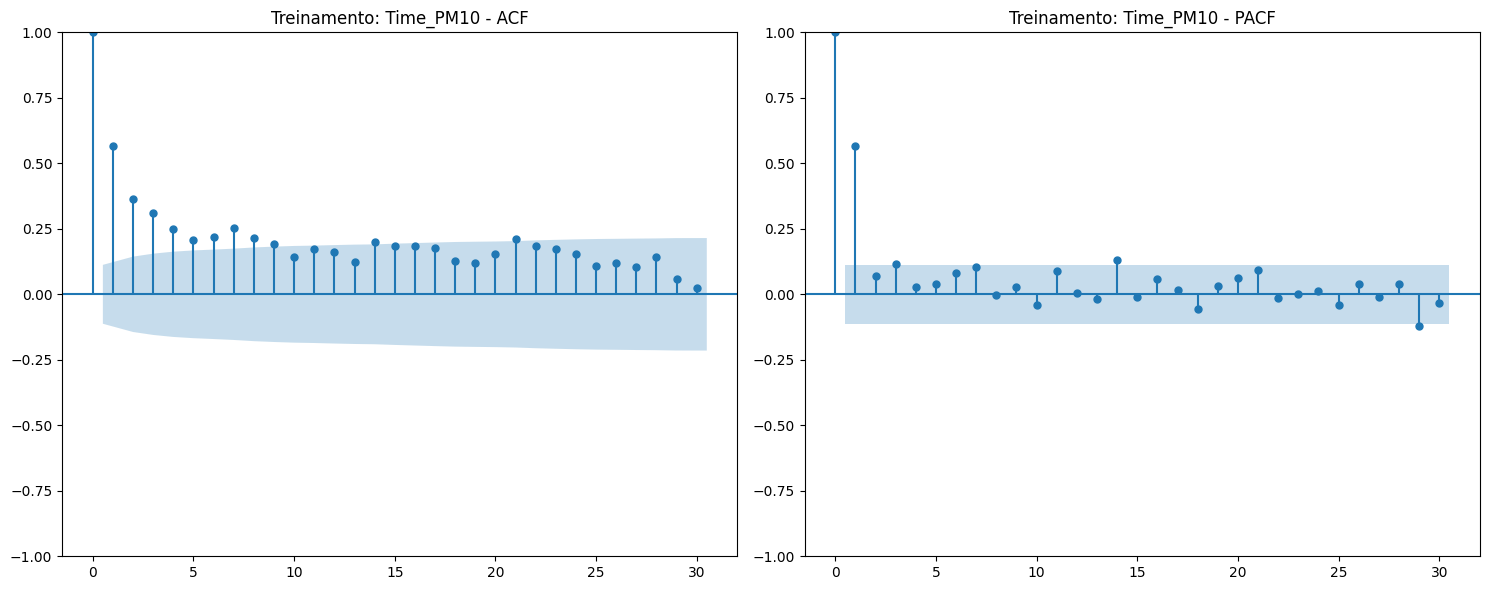

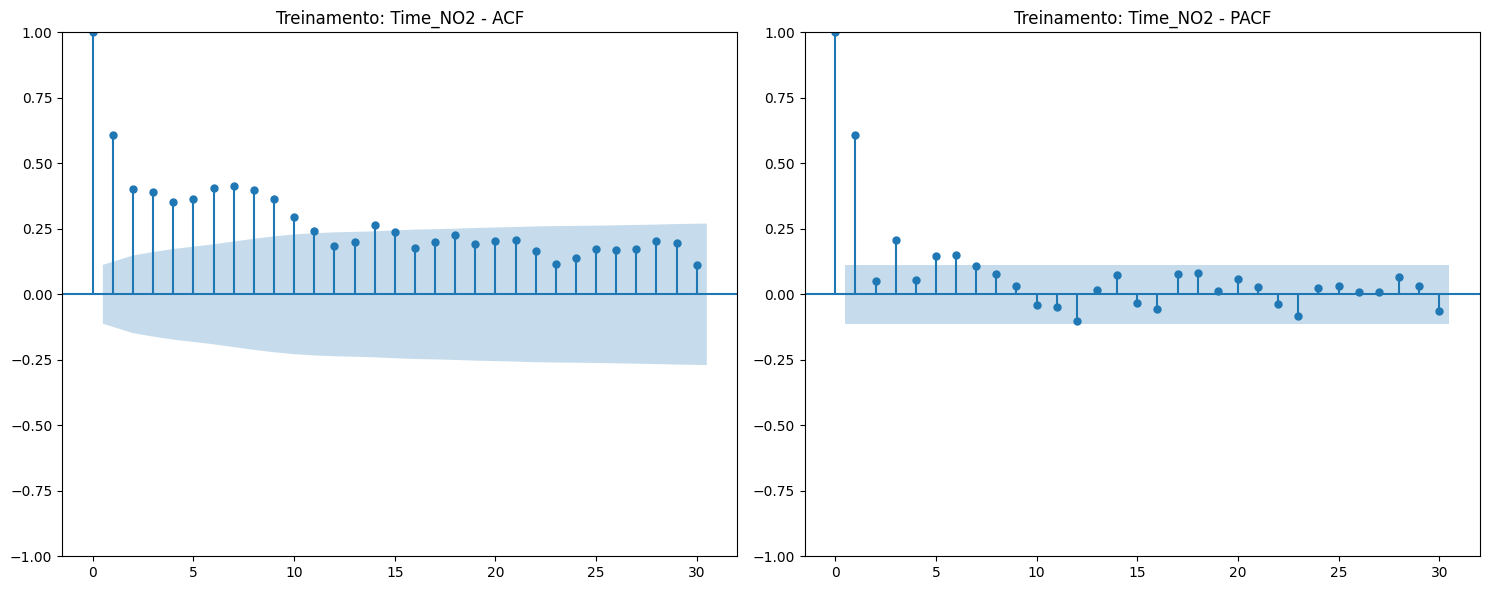

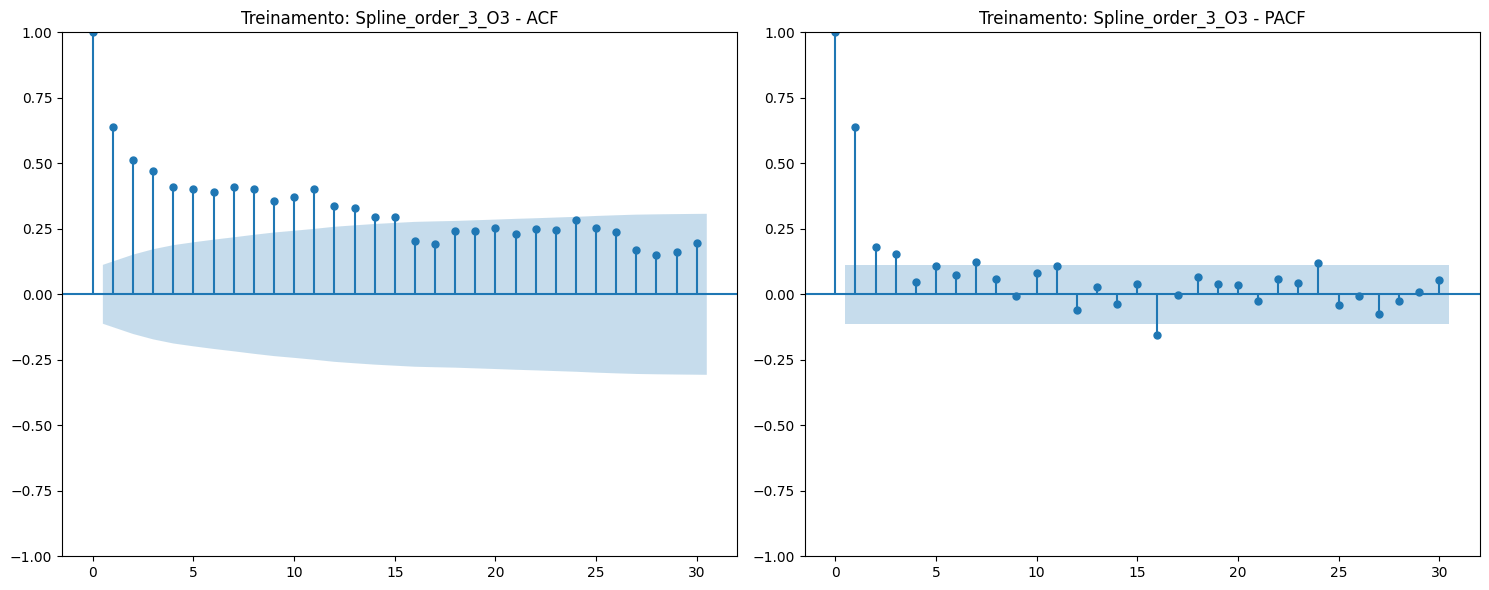

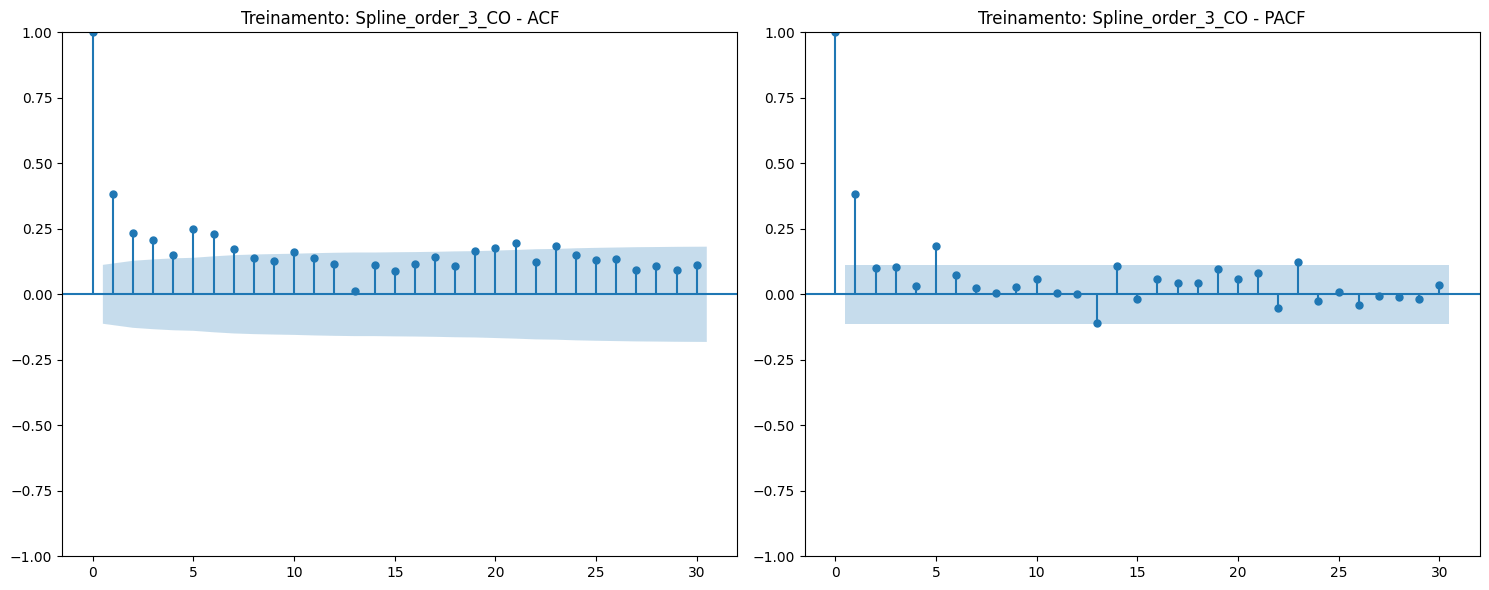

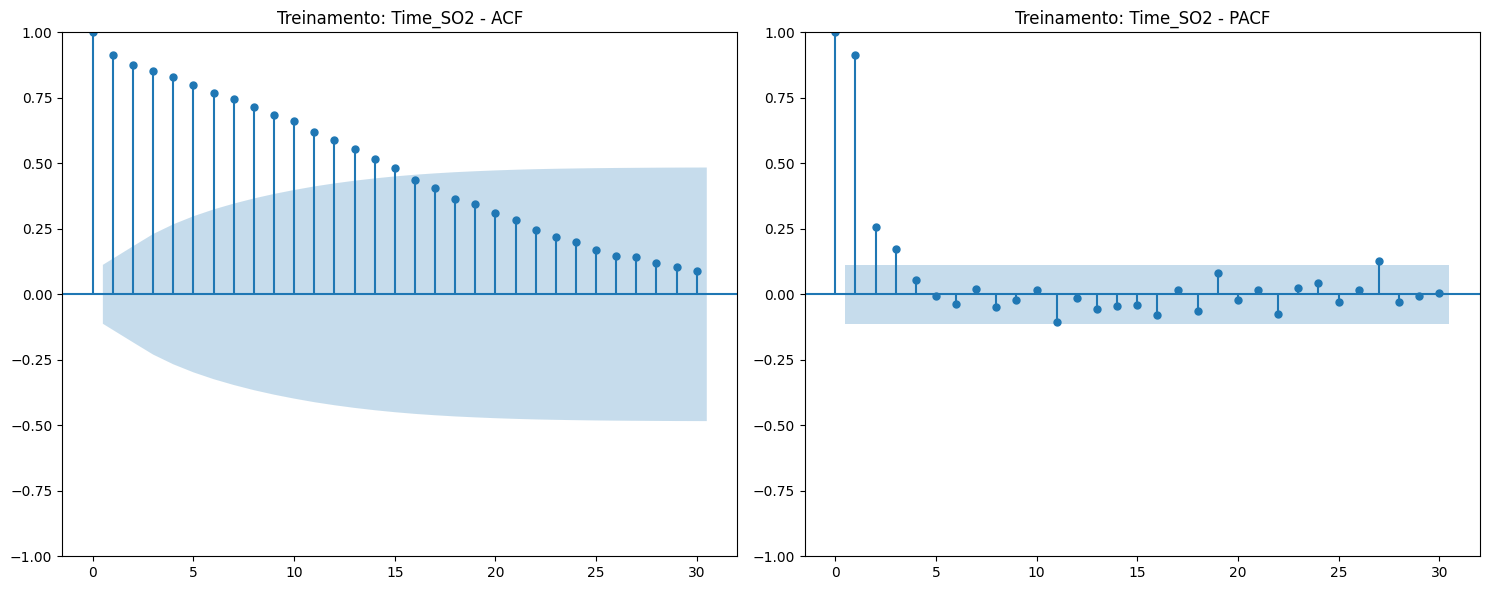

In [101]:
# Para o conjunto de treinamento
for column in train_data_normalized.columns:
    acf_pacf(train_data_normalized[column], lags=30, title_prefix=f"Treinamento: {column}")

In [102]:
#a SO2 ACF indica que nao é estacionaria devido ao caimento,Lag significativos (fora da faixa azul sombreada) sugerem uma dependência relevante da série até aproximadamente o lag 20-25
#Picos em lags baixos (lag 1 e lag 2, por exemplo) indicam que um modelo AR (AutoRegressive) de baixa ordem pode capturar bem os padrões da série.
#Após lag 3, os valores caem para dentro da faixa azul, indicando que os lags seguintes têm pouca contribuição direta.
#ja a  CO tem um comportamento que pode indicar que ela seja estacionaria

In [103]:
train_data_normalized.columns

Index(['Time_PM10', 'Time_NO2', 'Spline_order_3_O3', 'Spline_order_3_CO',
       'Time_SO2'],
      dtype='object')

In [104]:
#quebrando em blocos
train_pm10=train_data_normalized['Time_PM10']
train_no2=train_data_normalized['Time_NO2']
train_o3=train_data_normalized['Spline_order_3_O3']
train_co=train_data_normalized['Spline_order_3_CO']
train_so2=train_data_normalized['Time_SO2']

test_pm10 =test_data_normalized['Time_PM10']
test_no2 =test_data_normalized['Time_NO2']
test_o3 =test_data_normalized['Spline_order_3_O3']
test_co =test_data_normalized['Spline_order_3_CO']
test_so2 =test_data_normalized['Time_SO2']

#janela

In [105]:

def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [106]:
#windows para cada coluna com 30
#pm10
windows_train_pm10 = create_sliding_windows(train_pm10, 30)
windows_test_pm10 = create_sliding_windows(test_pm10,30)
#no2
windows_train_no2 = create_sliding_windows(train_no2, 30)
windows_test_no2 = create_sliding_windows(test_no2,30)
#o3
windows_train_o3 = create_sliding_windows(train_o3, 30)
windows_test_o3 = create_sliding_windows(test_o3,30)
#co

windows_train_co = create_sliding_windows(train_co, 30)
windows_test_co = create_sliding_windows(test_co,30)
#co
windows_train_so2 = create_sliding_windows(train_so2, 30)
windows_test_so2  = create_sliding_windows(test_so2,30)

##vendo as janelas

In [107]:
#primeira janla
windows_train_so2[0]

array([1.        , 0.93548387, 0.93548387, 0.93548387, 0.93548387,
       0.90322581, 0.93548387, 0.96774194, 0.93548387, 0.93548387,
       0.93548387, 0.93548387, 0.93548387, 0.90322581, 0.93548387,
       0.89247312, 0.84946237, 0.80645161, 0.7562724 , 0.70609319,
       0.65591398, 0.60573477, 0.55555556, 0.50537634, 0.45519713,
       0.40501792, 0.35483871, 0.32258065, 0.29032258, 0.29032258,
       0.29032258])

In [108]:
windows_train_so2[1]

array([0.93548387, 0.93548387, 0.93548387, 0.93548387, 0.90322581,
       0.93548387, 0.96774194, 0.93548387, 0.93548387, 0.93548387,
       0.93548387, 0.93548387, 0.90322581, 0.93548387, 0.89247312,
       0.84946237, 0.80645161, 0.7562724 , 0.70609319, 0.65591398,
       0.60573477, 0.55555556, 0.50537634, 0.45519713, 0.40501792,
       0.35483871, 0.32258065, 0.29032258, 0.29032258, 0.29032258,
       0.41935484])

In [109]:
windows_train_so2[2]

array([0.93548387, 0.93548387, 0.93548387, 0.90322581, 0.93548387,
       0.96774194, 0.93548387, 0.93548387, 0.93548387, 0.93548387,
       0.93548387, 0.90322581, 0.93548387, 0.89247312, 0.84946237,
       0.80645161, 0.7562724 , 0.70609319, 0.65591398, 0.60573477,
       0.55555556, 0.50537634, 0.45519713, 0.40501792, 0.35483871,
       0.32258065, 0.29032258, 0.29032258, 0.29032258, 0.41935484,
       0.3655914 ])

In [110]:
#antes da ultimma
windows_train_so2[-2]

array([0.4516129 , 0.4516129 , 0.4516129 , 0.4516129 , 0.4516129 ,
       0.48387097, 0.5483871 , 0.4516129 , 0.48387097, 0.4516129 ,
       0.4516129 , 0.51612903, 0.4516129 , 0.48387097, 0.48387097,
       0.51612903, 0.5483871 , 0.48387097, 0.5483871 , 0.4516129 ,
       0.4516129 , 0.48387097, 0.48387097, 0.51612903, 0.51612903,
       0.5483871 , 0.5483871 , 0.61290323, 0.5483871 , 0.51612903,
       0.5483871 ])

In [111]:
#ultima janela
windows_train_so2[-1]

array([0.4516129 , 0.4516129 , 0.4516129 , 0.4516129 , 0.48387097,
       0.5483871 , 0.4516129 , 0.48387097, 0.4516129 , 0.4516129 ,
       0.51612903, 0.4516129 , 0.48387097, 0.48387097, 0.51612903,
       0.5483871 , 0.48387097, 0.5483871 , 0.4516129 , 0.4516129 ,
       0.48387097, 0.48387097, 0.51612903, 0.51612903, 0.5483871 ,
       0.5483871 , 0.61290323, 0.5483871 , 0.51612903, 0.5483871 ,
       0.51612903])

#validação

In [112]:
perc_val = 0.2  # 20% para validação

# SO2
tam_val_so2 = int(len(windows_train_so2) * perc_val)
X_train_so2, y_train_so2 = windows_train_so2[:-tam_val_so2,:-1], windows_train_so2[:-tam_val_so2, -1]
X_val_so2, y_val_so2 = windows_train_so2[-tam_val_so2:, :-1], windows_train_so2[-tam_val_so2:, -1]

# CO
tam_val_co = int(len(windows_train_co) * perc_val)
X_train_co, y_train_co = windows_train_co[:-tam_val_co, :-1], windows_train_co[:-tam_val_co, -1]
X_val_co, y_val_co = windows_train_co[-tam_val_co:, :-1], windows_train_co[-tam_val_co:, -1]

# NO2
tam_val_no2 = int(len(windows_train_no2) * perc_val)
X_train_no2, y_train_no2 = windows_train_no2[:-tam_val_no2, :-1], windows_train_no2[:-tam_val_no2, -1]
X_val_no2, y_val_no2 = windows_train_no2[-tam_val_no2:, :-1], windows_train_no2[-tam_val_no2:, -1]

# O3
tam_val_o3 = int(len(windows_train_o3) * perc_val)
X_train_o3, y_train_o3 = windows_train_o3[:-tam_val_o3, :-1], windows_train_o3[:-tam_val_o3, -1]
X_val_o3, y_val_o3 = windows_train_o3[-tam_val_o3:, :-1], windows_train_o3[-tam_val_o3:, -1]

# PM10
tam_val_pm10 = int(len(windows_train_pm10) * perc_val)
X_train_pm10, y_train_pm10 = windows_train_pm10[:-tam_val_pm10, :-1], windows_train_pm10[:-tam_val_pm10, -1]
X_val_pm10, y_val_pm10 = windows_train_pm10[-tam_val_pm10:, :-1], windows_train_pm10[-tam_val_pm10:, -1]


##test

In [113]:
# SO2
X_test_so2, y_test_so2 = windows_test_so2[:, 0:-1], windows_test_so2[:, -1]
# CO
X_test_co, y_test_co = windows_test_co[:, 0:-1], windows_test_co[:, -1]
# NO2
X_test_no2, y_test_no2 = windows_test_no2[:, 0:-1], windows_test_no2[:, -1]
# O3
X_test_o3, y_test_o3 = windows_test_o3[:, 0:-1], windows_test_o3[:, -1]
# PM10
X_test_pm10, y_test_pm10 = windows_test_pm10[:, 0:-1], windows_test_pm10[:, -1]

#Selecionar lag

In [114]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    #x = serie[0: max_lag+1]

    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05)

    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x

    lags_selecionados = []

    for i in range(1, max_lag+1):


        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0

    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #inverte o valor dos lags para usar na lista de dados
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]



    return lags_selecionados

###pm10

In [115]:
lags_chosen_pm10 = select_lag_acf(train_pm10, 30)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 20]


In [116]:
#Selecionar apenas os lags mais relevantes para treinamento ou análise
X_train_pm10[0,lags_chosen_pm10]

array([0.34567901, 0.37037037, 0.33333333, 0.51851852, 0.34567901,
       0.2962963 , 0.33333333, 0.39506173, 0.60493827, 0.24691358,
       0.40740741])

In [117]:
#𝑦train contém os valores que o modelo deve prever.
y_train_pm10[0]

0.32098765432098764

In [118]:
#Selecionar apenas os lags mais relevantes para treinamento ou análise
X_train_pm10[1,lags_chosen_pm10]

array([0.32098765, 0.34567901, 0.37037037, 0.33333333, 0.51851852,
       0.34567901, 0.2962963 , 0.33333333, 0.39506173, 0.2345679 ,
       0.24691358])

In [119]:
#
y_train_pm10[1]

0.4444444444444445

In [120]:
#Selecionar apenas os lags mais relevantes para treinamento ou análise
X_train_pm10[2,lags_chosen_pm10]

array([0.44444444, 0.32098765, 0.34567901, 0.37037037, 0.33333333,
       0.51851852, 0.34567901, 0.2962963 , 0.33333333, 0.2345679 ,
       0.2962963 ])

###so2

In [121]:
lags_chosen_so2 = select_lag_acf(train_so2, 30)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [122]:
X_train_so2[0,lags_chosen_so2]

array([0.29032258, 0.29032258, 0.32258065, 0.35483871, 0.40501792,
       0.45519713, 0.50537634, 0.55555556, 0.60573477, 0.65591398,
       0.70609319, 0.7562724 , 0.80645161, 0.84946237, 0.89247312])

In [123]:
#𝑦train contém os valores que o modelo deve prever.
y_train_so2[0]

0.29032258064516125

###no2

In [124]:
lags_chosen_no2 = select_lag_acf(train_no2, 30)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13]


In [125]:
X_train_no2[0,lags_chosen_no2]

array([0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. , 0. ])

In [126]:
y_train_no2[0]

0.1

###o3

In [127]:
lags_chosen_o3 = select_lag_acf(train_o3, 30)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [128]:

X_train_o3[0,lags_chosen_o3]

array([0.18218153, 0.18218153, 0.1754781 , 0.20229182, 0.13525752,
       0.11514723, 0.14866438, 0.14196095, 0.16207124, 0.15536781,
       0.12185066, 0.14866438, 0.14866438, 0.15865264, 0.16507927])

In [129]:
y_train_o3[0]

0.1888849621500044

###co

In [130]:

lags_chosen_co = select_lag_acf(train_co, 30)

LAGS [0, 1, 2, 3, 4, 5, 6, 9, 18, 19, 20, 22]


In [131]:

X_train_co[0,lags_chosen_co]

array([0.19444444, 0.30555556, 0.25      , 0.27777778, 0.22222222,
       0.11111111, 0.44444444, 0.11111111, 0.25      , 0.30555556,
       0.55555556, 0.08333333])

In [132]:
y_train_co[0]

0.25

#treinamento E MODELAGEM

###pm10

In [139]:
X_train_acf_pm10 = X_train_pm10[:, lags_chosen_pm10]
X_val_acf_pm10 = X_val_pm10[:,lags_chosen_pm10]
X_test_acf_pm10 = X_test_pm10[:, lags_chosen_pm10]


##no2

In [140]:

X_train_acf_no2 = X_train_no2[:, lags_chosen_no2]
X_val_acf_no2 = X_val_no2[:,lags_chosen_no2]
X_test_acf_no2 = X_test_no2[:, lags_chosen_no2]


##so2

In [141]:
X_train_acf_so2 = X_train_so2[:, lags_chosen_so2]
X_val_acf_so2 = X_val_so2[:,lags_chosen_so2]
X_test_acf_so2 = X_test_so2[:, lags_chosen_so2]


##o3

In [142]:

X_train_acf_o3 = X_train_o3[:, lags_chosen_o3]
X_val_acf_o3 = X_val_o3[:,lags_chosen_o3]
X_test_acf_o3 = X_test_o3[:, lags_chosen_o3]


##co

In [143]:
X_train_acf_co = X_train_co [:, lags_chosen_co ]
X_val_acf_co  = X_val_co [:,lags_chosen_co ]
X_test_acf_co = X_test_co[:, lags_chosen_co ]


#SEED

##MLP - TREINAMENTO

In [144]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):

    neuronios = [5, 10,25]
    func_activation = [ 'tanh','logistic', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']

    max_iteracoes = [5000, 10000, 20000]  # Tente valores maiore
    learning_rate = ['adaptive']#, 'invscaling', 'adaptive']

    best_result = np.Inf
    """para otimizar o código reduzindo os laços utilize o itertools:

    import itertools
    hyper_param = list(itertools.product(neuronios,func_activation,alg_treinamento,max_iteracoes, learning_rate))
    for i, j, l, m, n in hyper_param:

    """

    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):

                        for e in range(0,num_exec):
                            mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                            mlp.fit(x_train, y_train)
                            predict_validation = mlp.predict(x_val)

                            mse = MSE(y_val, predict_validation)


                            if mse < best_result:
                                best_result = mse
                                select_model = mlp
                                print('func: ', func_activation[j])





    return select_model

##pm10 - treinamento MLP

In [157]:
modelo_PM10 =  treinar_mlp(X_train_acf_pm10, y_train_pm10, X_val_acf_pm10, y_val_pm10, 4)

func:  tanh
func:  tanh
func:  tanh
func:  logistic
func:  logistic
func:  tanh
func:  relu


In [158]:
trainPredict_pm10 = modelo_PM10.predict(X_train_acf_pm10)

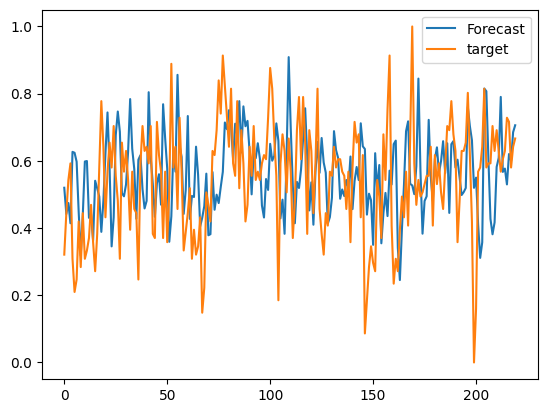

In [159]:
plt.plot(trainPredict_pm10, label='Forecast')
plt.plot(y_train_pm10, label='target')
plt.legend()
plt.show()

In [148]:
MSE(y_train_pm10,trainPredict_pm10 )

0.025266840347326066

In [149]:
predictRealInterval = scaler_pm10.inverse_transform(trainPredict_pm10.reshape(1, -1))


In [150]:
targetRealInterval =  scaler_pm10 .inverse_transform(y_train_pm10.reshape(1, -1) )

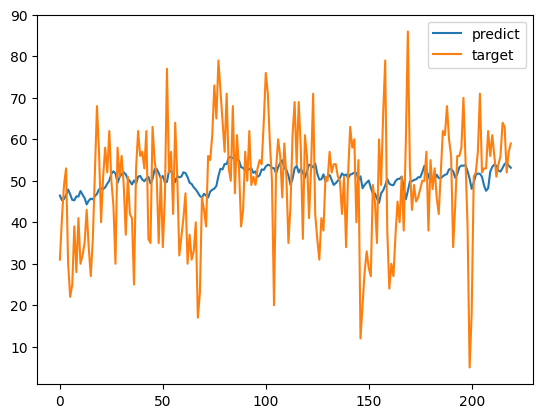

In [151]:

plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [152]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100

In [153]:
MSE(targetRealInterval,predictRealInterval)

165.77573951880638

In [154]:
MAPE(targetRealInterval,predictRealInterval)

29.505979866946213

###pm10_teste _mlp

In [160]:

testPredict_pm10 = modelo_PM10.predict(X_test_acf_pm10)

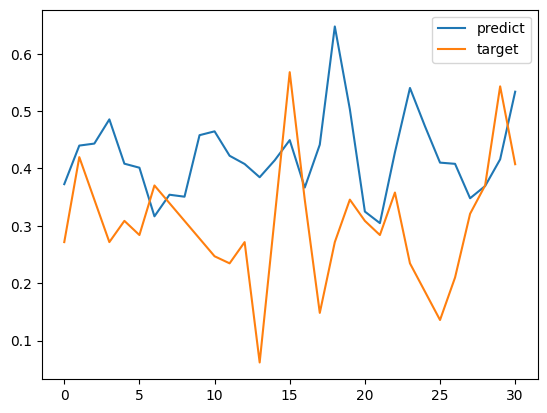

In [161]:
plt.plot(testPredict_pm10, label = 'predict')
plt.plot(y_test_pm10, label= 'target')
plt.legend()
plt.show()

In [175]:
predictRealInterval = scaler_pm10.inverse_transform(testPredict_pm10.reshape(1, -1))

In [176]:
targetRealInterval =  scaler_pm10.inverse_transform(y_test_pm10.reshape(1, -1) )

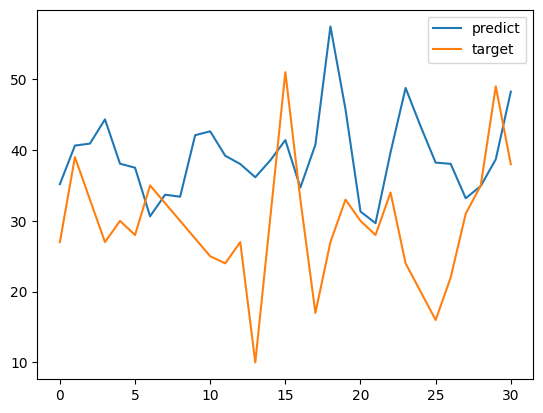

In [177]:
plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [178]:
MAPE(targetRealInterval[0], predictRealInterval[0] )

50.20391521156331

##o3

In [164]:
modelo_O3 =  treinar_mlp(X_train_acf_o3, y_train_o3, X_val_acf_o3, y_val_o3, 4)


func:  tanh
func:  tanh
func:  tanh
func:  tanh
func:  tanh
func:  logistic
func:  logistic
func:  logistic
func:  logistic
func:  tanh


In [165]:
trainPredict_o3 = modelo_O3.predict(X_train_acf_o3)

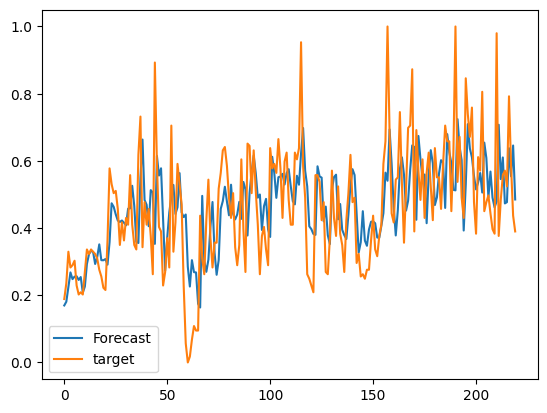

In [166]:
plt.plot(trainPredict_o3, label='Forecast')
plt.plot(y_train_o3, label='target')
plt.legend()
plt.show()

In [167]:
MSE(y_train_o3,trainPredict_o3 )

0.022172921900019148

In [168]:
predictRealInterval = scaler_o3.inverse_transform(trainPredict_o3.reshape(1, -1))

In [169]:
targetRealInterval =  scaler_o3 .inverse_transform(y_train_o3.reshape(1, -1) )

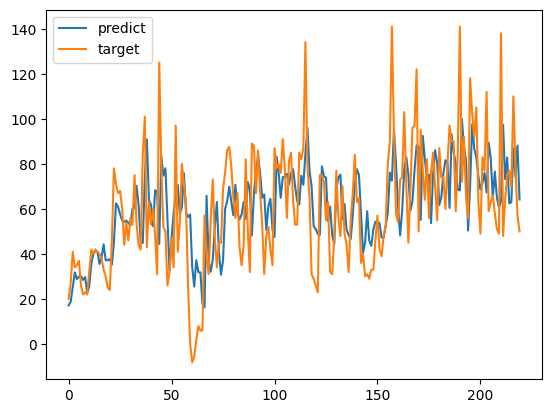

In [170]:
plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [171]:

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100

In [172]:
MSE(targetRealInterval,predictRealInterval)

493.4336482134556

In [173]:
MAPE(targetRealInterval,predictRealInterval)

134.8673906951316

###o3_teste _mlp

In [179]:
testPredict_o3 = modelo_O3.predict(X_test_acf_o3)

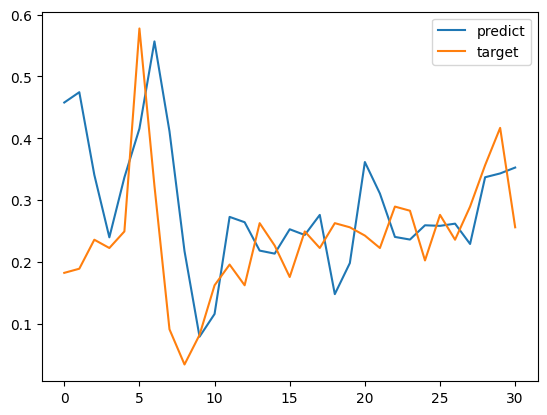

In [181]:
plt.plot(testPredict_o3, label = 'predict')
plt.plot(y_test_o3, label= 'target')
plt.legend()
plt.show()

In [182]:

predictRealInterval = scaler_o3.inverse_transform(testPredict_o3.reshape(1, -1))

In [183]:

targetRealInterval =  scaler_o3.inverse_transform(y_test_o3.reshape(1, -1) )

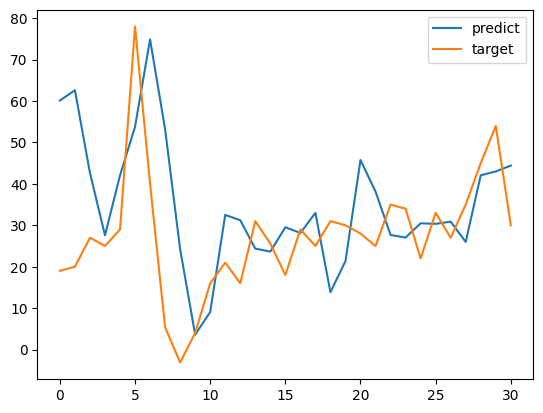

In [184]:

plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [185]:
MAPE(targetRealInterval[0], predictRealInterval[0] )

102.04016074418236

##co

In [190]:
modelo_CO =  treinar_mlp(X_train_acf_co, y_train_co, X_val_acf_co, y_val_co, 4)

func:  tanh
func:  tanh
func:  tanh
func:  tanh
func:  tanh
func:  logistic
func:  logistic


In [191]:
trainPredict_co = modelo_CO.predict(X_train_acf_co)

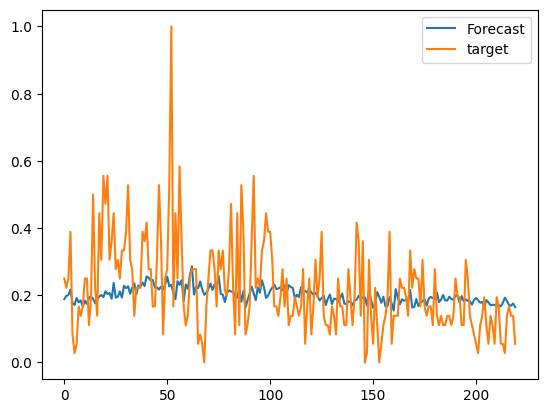

In [192]:
plt.plot(trainPredict_co, label='Forecast')
plt.plot(y_train_co, label='target')
plt.legend()
plt.show()

In [193]:

MSE(y_train_co,trainPredict_co )

0.016862854565529

In [194]:

predictRealInterval = scaler_co.inverse_transform(trainPredict_co.reshape(1, -1))
targetRealInterval =  scaler_co.inverse_transform(y_train_co.reshape(1, -1) )


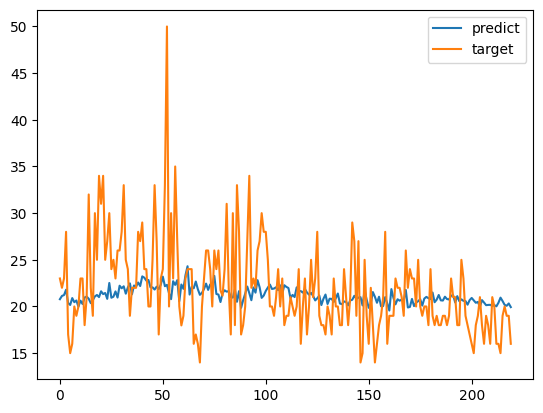

In [195]:

plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [196]:


def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100


In [197]:

MSE(targetRealInterval,predictRealInterval)

21.854259516925588

In [198]:
MAPE(targetRealInterval,predictRealInterval)

15.103525815881111

###teste Co

In [199]:
testPredict_co = modelo_CO.predict(X_test_acf_co)

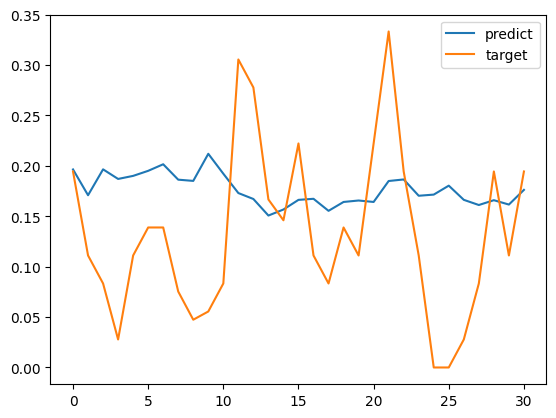

In [200]:
plt.plot(testPredict_co, label = 'predict')
plt.plot(y_test_co, label= 'target')
plt.legend()
plt.show()

In [201]:

predictRealInterval = scaler_co.inverse_transform(testPredict_co.reshape(1, -1))


In [202]:

targetRealInterval =  scaler_co.inverse_transform(y_test_co.reshape(1, -1) )

In [204]:
MAPE(targetRealInterval[0], predictRealInterval[0] )

16.775397576562916

##no2

In [205]:
modelo_NO2 =  treinar_mlp(X_train_acf_no2, y_train_no2, X_val_acf_no2, y_val_no2, 4)

func:  tanh
func:  tanh
func:  logistic
func:  logistic
func:  logistic
func:  relu


In [206]:
trainPredict_no2 = modelo_NO2 .predict(X_train_acf_no2)

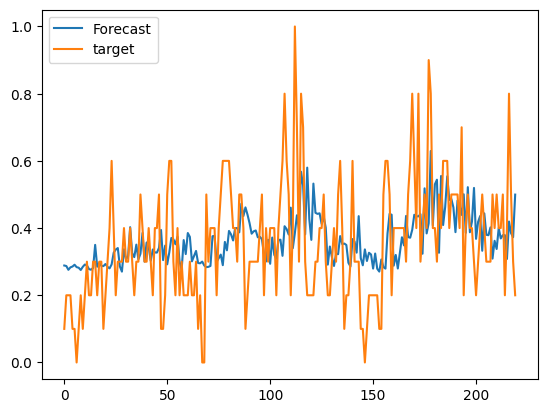

In [207]:
plt.plot(trainPredict_no2, label='Forecast')
plt.plot(y_train_no2, label='target')
plt.legend()
plt.show()

In [208]:
MSE(y_train_no2,trainPredict_no2)

0.02680080525357311

In [209]:
predictRealInterval = scaler_no2.inverse_transform(trainPredict_no2.reshape(1, -1))
targetRealInterval =  scaler_no2.inverse_transform(y_train_no2.reshape(1, -1) )

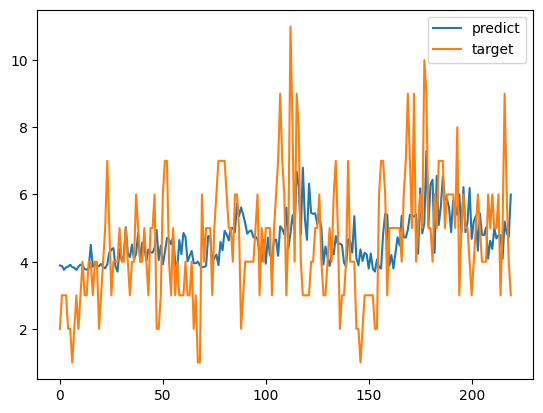

In [210]:

plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [211]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100

In [212]:
MSE(targetRealInterval,predictRealInterval)

2.6800805253573095

In [213]:
MAPE(targetRealInterval,predictRealInterval)

36.28679330479147

###teste no2

In [214]:
testPredict_no2 = modelo_NO2.predict(X_test_acf_no2)


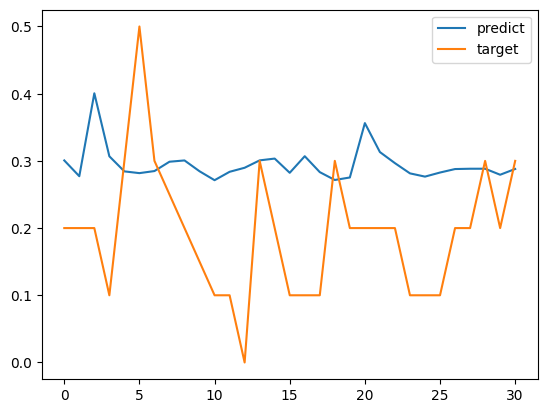

In [215]:
plt.plot(testPredict_no2, label = 'predict')
plt.plot(y_test_no2, label= 'target')
plt.legend()
plt.show()

In [218]:
predictRealInterval = scaler_no2.inverse_transform(testPredict_no2.reshape(1, -1))


In [219]:

targetRealInterval =  scaler_no2.inverse_transform(y_test_no2.reshape(1, -1) )

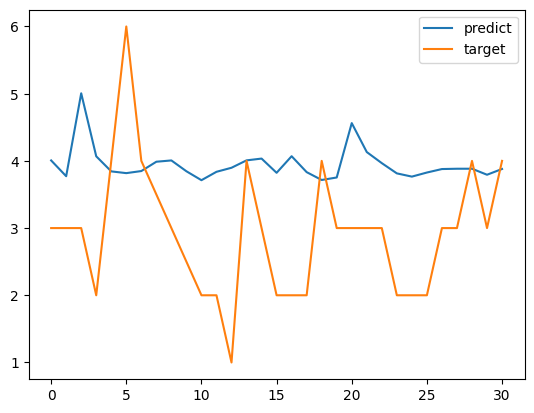

In [220]:
plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [221]:
MAPE(targetRealInterval[0], predictRealInterval[0] )

54.15052250707182

##so2

In [217]:
modelo_SO2 =  treinar_mlp(X_train_acf_so2, y_train_so2, X_val_acf_so2, y_val_so2,4)


func:  tanh
func:  tanh
func:  tanh
func:  tanh


In [222]:
trainPredict_so2 = modelo_SO2 .predict(X_train_acf_so2)

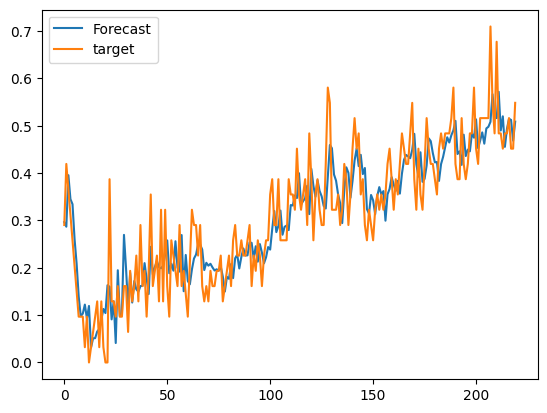

In [223]:
plt.plot(trainPredict_so2, label='Forecast')
plt.plot(y_train_so2, label='target')
plt.legend()
plt.show()

In [224]:
MSE(y_train_so2,trainPredict_so2 )

0.004368893339235708

In [225]:

predictRealInterval = scaler_so2.inverse_transform(trainPredict_so2.reshape(1, -1))
targetRealInterval =  scaler_so2.inverse_transform(y_train_so2.reshape(1, -1) )


In [226]:


def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100

In [227]:


MSE(targetRealInterval,predictRealInterval)

4.198506499005515

In [228]:
MAPE(targetRealInterval,predictRealInterval)

15.31077809308109

###teste so2

In [229]:
testPredict_so2= modelo_SO2.predict(X_test_acf_so2)

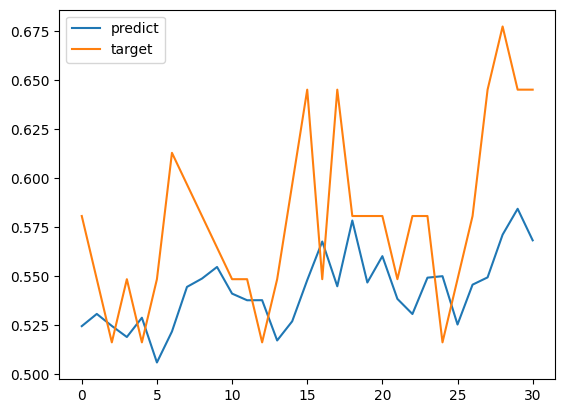

In [230]:
plt.plot(testPredict_so2, label = 'predict')
plt.plot(y_test_so2, label= 'target')
plt.legend()
plt.show()

In [231]:

predictRealInterval = scaler_so2.inverse_transform(testPredict_so2.reshape(1, -1))


In [232]:

targetRealInterval =  scaler_so2.inverse_transform(y_test_so2.reshape(1, -1) )

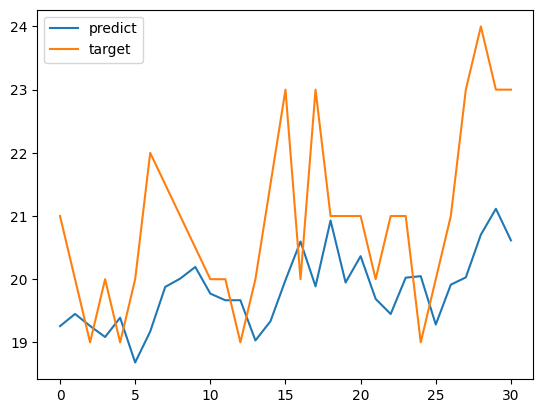

In [233]:
plt.plot(predictRealInterval[0], label = 'predict')
plt.plot(targetRealInterval[0], label= 'target')
plt.legend()
plt.show()

In [234]:
MAPE(targetRealInterval[0], predictRealInterval[0] )

5.953989232543164

#nada

#lstm

In [ ]:
import itertools
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as MSE

def train_lstm(x_train, y_train, x_val, y_val, num_exec=1):
    """
    Trains an LSTM model with hyperparameter search and Early Stopping.

    Args:
        x_train (np.ndarray): Training data features.
        y_train (np.ndarray): Training data labels.
        x_val (np.ndarray): Validation data features.
        y_val (np.ndarray): Validation data labels.
        num_exec (int, optional): Number of times to execute each hyperparameter
                                  combination (default: 1).

    Returns:
        tensorflow.keras.Model: The best performing LSTM model.
    """

    # Hyperparameters to test
    neuronios = [32, 64, 128]
    func_activation = ['tanh', 'relu']
    alg_treinamento = ['adam', 'sgd']
    learning_rates = [0.001, 0.01]
    dropouts = [0.1, 0.2, 0.3]
    epochs = [5, 10, 20, 50, 100]
    batch_sizes = [32, 64]

    best_result = np.Inf
    select_model = None

    # Efficient hyperparameter search using itertools.product
    hyper_params = list(itertools.product(neuronios, func_activation,
                                          alg_treinamento, learning_rates, dropouts, epochs, batch_sizes))

    for params in hyper_params:
        for _ in range(num_exec):  # Execute each combination once (num_exec=1)
            try:
                # Create LSTM model
                model = Sequential([
                    Input(shape=(x_train.shape[1], x_train.shape[2])),  # Input layer
                    LSTM(params[0], activation=params[1]),  # LSTM layer
                    Dropout(params[4]),  # Dropout layer to prevent overfitting
                    Dense(1)  # Output layer
                ])

                # Choose optimizer based on user choice
                if params[2] == 'adam':
                    optimizer = Adam(learning_rate=params[3])
                elif params[2] == 'sgd':
                    optimizer = SGD(learning_rate=params[3])

                # Compile model with MSE loss and Early Stopping
                model.compile(optimizer=optimizer, loss='mse')
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                # Train model with Early Stopping
                history = model.fit(
                    x_train, y_train,
                    epochs=params[5],
                    batch_size=params[6],
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping],
                    verbose=0  # Suppress training messages
                )

                # Evaluate and update best model
                y_pred_val = model.predict(x_val)
                mse = MSE(y_val, y_pred_val)
                if mse < best_result:
                    best_result = mse
                    select_model = model
                    print(f"Novo melhor modelo: Neuronios={params[0]}, Ativação={params[1]}, "
                          f"Otimizador={params[2]}, Learning Rate={params[3]}, Dropout={params[4]}, "
                          f"Epochs={params[5]}, Batch Size={params[6]}, MSE={mse:.4f}")

            except Exception as e:
                print(f"Erro com parâmetros: {params}, Execução {_ + 1}")
                print(str(e))
                continue

    return select_model


pm10

In [ ]:

print(f"Formato do conjunto de treinamento: {X_train_pm10.shape}, {y_train_pm10.shape}")
print(f"Formato do conjunto de validação: {X_val_pm10.shape}, {y_val_pm10.shape}")
print(f"Formato do conjunto de teste: {X_test_pm10.shape}, {y_test_pm10.shape}")

Formato do conjunto de treinamento: (220, 30), (220,)
Formato do conjunto de validação: (54, 30), (54,)
Formato do conjunto de teste: (31, 30), (31,)


In [ ]:
# Expandindo as dimensões para incluir o número de features (1)
X_train_pm10 = X_train_pm10.reshape((X_train_pm10.shape[0], X_train_pm10.shape[1], 1))
X_val_pm10 = X_val_pm10.reshape((X_val_pm10.shape[0], X_val_pm10.shape[1], 1))
X_test_pm10 = X_test_pm10.reshape((X_test_pm10.shape[0], X_test_pm10.shape[1], 1))

print(f"Novo formato do conjunto de treinamento: {X_train_pm10.shape}, {y_train_pm10.shape}")
print(f"Novo formato do conjunto de validação: {X_val_pm10.shape}, {y_val_pm10.shape}")
print(f"Novo formato do conjunto de teste: {X_test_pm10.shape}, {y_test_pm10.shape}")


Novo formato do conjunto de treinamento: (220, 30, 1), (220,)
Novo formato do conjunto de validação: (54, 30, 1), (54,)
Novo formato do conjunto de teste: (31, 30, 1), (31,)


pm10

In [ ]:
# Chamar a função para treinar o LSTM
best_lstm_model_pm10 = train_lstm(X_train_pm10, y_train_pm10, X_val_pm10, y_val_pm10,num_exec=3)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Novo melhor modelo: Neuronios=32, Ativação=tanh, Otimizador=adam, Learning Rate=0.001, Dropout=0.1, Epochs=5, Batch Size=32, MSE=0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
Novo melhor modelo: Neuronios=32, Ativação=tanh, Otimizador=adam, Learning Rate=0.001, Dropout=0.1, Epochs=5, Batch Size=32, MSE=0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Novo melhor modelo: Neuronios=32, Ativação=tanh, Otimizador=adam, Learning Rate=0.001, Dropout=0.1, Epochs=10, Batch Size=32, MSE=0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Novo m

In [ ]:
# Chamar a função para treinar o LSTM
best_lstm_model__co = treinar_lstm(X_train_co, y_train_co, X_val_co, y_val_co,num_exec=3)


In [ ]:
# Chamar a função para treinar o LSTM
best_lstm_model__o3 = treinar_lstm(X_train_o3, y_train_o3, X_val_o3, y_val_o3 ,num_exec=3)

##OUTRO LSTM

#Sarima


#comentarios
REGRESSION TASK --> CRIAR JANELAS ,
vetor,treinamento ,normalizar - por ter sarima ,janelas para o modelo , previsao

FAZER PREVISAO,testar com diferentes hiperparametros , fazendo de forma sistematica, ,NIXTLA - biblioteca utiliza em series temporais , avançados , parte de previsao  


#correção de tipos do conjunto= feito
#retirada de colunas não pertinentes = feito
#seleção de apenas uma area do territorio pra ser investigada= feito
#transformação do datatime = feito
#retirada de duplicadas = feito
#index datatime = feito
#heatmap - coorelaçao = feito
#acf  = nao realizado
#interpolar primeiro = feito
# diferenciação para variavel time so2 que nao é estacionaria = nao feito
#sepração teinamento e teste = feito
#fit APENAS NO TREINAMENTO = feito
#normalização =feito
#criação dos coorelogramas = feito
#criando create_sliding_windows  for which feature/variable = feito
#after that i think that iam suppoed to select lag s=  feito

#regresstion probleam
#than after select the best or better lags i think that i need to model and train using maybe itertools to finf  a better func_activation
#than plt.plot(trainPredict, label='Forecast')
#plt.plot(y_train, label='target')
#plt.legend()
#plt.show()


In [ ]:
https://medium.com/@ozdogar/time-series-forecasting-using-sarima-python-8db28f1d8cfc

In [ ]:
#correção de tipos do conjunto= feito
#retirada de colunas não pertinentes = feito
#seleção de apenas uma area do territorio pra ser investigada= feito
#transformação do datatime = feito
#retirada de duplicadas = feito
#index datatime = feito
#heatmap - coorelaçao = feito
#acf  = nao realizado
#interpolar primeiro = feito
# diferenciação para variavel time so2 que nao é estacionaria = nao feito
#sepração teinamento e teste = feito

#fit APENAS NO TREINAMENTO = feito
#normalização =feito
#criação dos coorelogramas = feito
#criando create_sliding_windows  = fazer

#regresssão
#time janela - como se fosse dois meses ajudando a prever o proximo mes
#primeiro fazer o split do conju, para nao influenciar o conjunto de treinamento na media dele


#Bom dia!
#Não precisa realizar a diferenciação. Após criar o janelamento vc segue como um problema de regressão onde o x é a janela e o y é o respectivo targe


SyntaxError: invalid syntax (<ipython-input-18-61e69e2d5a2c>, line 4)

In [ ]:
#

#time janela - como se fosse dois meses ajudando a prever o proximo mes
#primeiro fazer o split do conju, para nao influenciar o conjunto de treinamento na media dele


#Bom dia!
#Não precisa realizar a diferenciação. Após criar o janelamento vc segue como um problema de regressão onde o x é a janela e o y é o respectivo target

#vetor,treinamento ,normalizar - por ter sarima ,janelas para o modelo , previsao

F#AZER PREVISAO,testar com diferentes hiperparametros , fazendo de forma sistematica, ,NIXTLA - biblioteca utiliza em series temporais , avançados , parte de previsao

In [ ]:
https://python.plainenglish.io/task-i-pythonizing-business-efficiency-bioenergy-supply-chain-optimization-089025c91183
https://github.com/huevosabio/ts-predict/blob/master/TS%20Forecasting%20Single-Step%20LSTM%20RNN.ipynb
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
https://onlinelibrary.wiley.com/doi/full/10.4218/etrij.2023-0283
#https://medium.com/@ozdogar/time-series-forecasting-using-sarima-python-8db28f1d8cfc

#referencia

In [ ]:
# D. J. P. E. Agency, Air Pollution Standard Index (ISPU) 2017 - Data and Resources
#https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6
#https://stackoverflow.com/questions/74510992/linear-regression-for-time-series
#https://medium.com/making-sense-of-data/time-series-next-value-prediction-using-regression-over-a-rolling-window-228f0acae363
#https://medium.com/@tirthamutha/time-series-forecasting-using-sarima-in-python-8b75cd3366f2
#https://github.com/marcopeix/time-series-analysis/blob/master/Advanced%20modelling/SARIMA.ipynb
This document provides information on the Air Pollution Standard Index (ISPU) for Jakarta in 2017, along with resources for further exploration and analysis of air quality data.

**Data Source:**

* The first link points to a potential data source for ISPU in 2017: [https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2017](https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2017) (Indonesian Government - Jakarta Open Data Platform)

**Additional Resources:**

* The document provides a comprehensive list of resources related to time series data analysis, forecasting, and visualization. These resources cover various aspects, including:
    * Data preprocessing techniques (normalization, scaling, handling missing values)
    * Time series forecasting models (ARIMA, LSTM, Prophet)
    * Techniques for evaluating forecasting models (MAPE, RMSE)
    * Data visualization for time series analysis

**Here's a breakdown of the resources by category:**

* **Data Preprocessing:**
    * [https://towardsdatascience.com/preprocessing-time-series-data-for-supervised-learning-2e27493f44ae](https://towardsdatascience.com/preprocessing-time-series-data-for-supervised-learning-2e27493f44ae)
    * [https://stackoverflow.com/questions/62033654/preprocessing-data-for-time-series-prediction](https://stackoverflow.com/questions/62033654/preprocessing-data-for-time-series-prediction)
    * [https://medium.com/@tubelwj/guide-to-time-series-data-pre-processing-methods-0a6df7ee054f](https://medium.com/@tubelwj/guide-to-time-series-data-pre-processing-methods-0a6df7ee054f)

* **Time Series Forecasting Models:**
    * [https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
    * [https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6](https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6)
    * [https://mariofilho.com/como-prever-series-temporais-com-lstm-em-python/](https://mariofilho.com/como-prever-series-temporais-com-lstm-em-python/) (LSTM in Python)
    * [invalid URL removed] (Exploring LSTM)
    * [https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) (LSTM with Keras)
    * [https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1](https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1) (Exploratory Data Analysis)
    * [https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/) (Developing LSTM Models)
    * [https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce](https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce) (TensorFlow LSTM)
    * [https://medium.com/@wainaina.pierre/the-complete-guide-to-time-series-forecasting-models-ef9c8cd40037](https://medium.com/@wainaina.pierre/the-complete-guide-to-time-series-forecasting-models-ef9c8cd40037) (Complete Guide)

* **Time Series Visualization:**
    * [https://datajournalism.com/read/handbook/one/understanding-data/using-data-visualization-to-find-insights-in-data](https://datajournalism.com/read/handbook/one/understanding-data/using-data-visualization-to-find-insights-in-data)

* **Time Series Analysis - General Resources:**
    * [https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide](https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide)
    * Several additional resources from Kaggle on time series analysis, forecasting, and exploration are provided.

* **Time Series Forecasting - Code Examples:**
    * Several code examples on various platforms (Kaggle) for time series forecasting with different models (ARIMA, LSTM, Prophet) are provided.
    * These resources can be helpful for implementing time series forecasting techniques in practice.

* **TensorFlow Tutorial:**
    * [https://www.tensorflow.org/tutorials/structured_data/time_series?hl=pt-br](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=pt-br) (TensorFlow Time Series Tutorial)

This list provides a valuable starting point for anyone interested in analyzing air quality data or exploring time series analysis in general.